In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import numba

from sample_processing import *
from gibbs_sampler import *
%load_ext autoreload
%autoreload 2

In [3]:
def calc_c_vals(cluster_sol, similarity_mat):
    
    c_vals = np.zeros(len(cluster_sol))
    for i in range(len(cluster_sol)):

        point_clust = cluster_sol[i]
        point_sims = similarity_mat[i]

        neighbs = np.where(cluster_sol==point_clust)[0]
        neighbs_sim = point_sims[neighbs]
        c_val_i = np.mean(neighbs_sim)
        c_vals[i] = c_val_i
        
        return c_vals
    
def confidence_matrix(cluster_sol, similarity_mat):
    
    # Get names of clusters
    sorted_clust_names = pd.Series(cluster_sol).value_counts().index

    # Re-arrange IDs and form new sorted similarity matrix
    arranged_ids = []
    for c in sorted_clust_names:

        clust_ids = np.where(cluster_sol==c)[0]
        c_vals_clust = c_vals[clust_ids]
        sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]

        arranged_ids.append(sorted_clust_ids)

    arranged_ids = np.concatenate(arranged_ids)

    sorted_matrix = np.zeros((len(cluster_sol),len(cluster_sol)))

    for i in range(len(cluster_sol)):
        for j in range(len(cluster_sol)):

            sorted_matrix[i,j] = sim_mat[arranged_ids[i], arranged_ids[j]]

# Prelim on Wildfire Data

In [4]:
# Create a StringIO object to simulate reading from a file-like object
from io import StringIO


def extract_state(input_string):
    # Use regular expression to extract text between five asterisks
    result = re.search(r'\*{5}\s*(.*?)\s*\*{1,5}', input_string)
    
    if result:
        extracted_text = result.group(1)
        return extracted_text
    else:
        return ""

def extract_content(in_string):
    fake_file = StringIO(in_string)

    # Define column widths based on the fixed-width format
    colspecs = [
        (0, 7), (7, 25), (25, 31), (31, 36), (36, 42),
        (42, 46), (47, 51), (51, 56), (56, 61), (62, 68),
        (68, 73), (73, 78), (78, 83), (83, 88), (89, 94),
        (94, 100), (101, 106), (106, 111), (111, 115), (115, 120)
    ]

    # Column names
    columns = ['Stn ID', 'Stn Name', 'Elev', 'Lat', 'Long',
               'Mdl', 'Tmp', 'RH', 'Wind', 'PPT',
               'ERC', 'BI', 'SC', 'KBDI', 'HUN',
               'THOU', 'TEN', 'STL', 'ADJ', 'IC']

    # Read the fixed-width format data into a DataFrame
    df = pd.read_fwf(fake_file, colspecs=colspecs, names=columns)
    
    return df

Load older dataset - For State names

In [5]:
import pandas as pd
import re

def extract_data_to_df(filepath):

    # Read the text file
    with open(filepath, 'r') as file:
        lines = file.readlines()


    # Initialize empty lists to store data
    data = {'Stn ID': [], 'Stn Name': [], 'Elev': [], 'Lat': [], 'Long': [],
            'Mdl': [], 'Tmp': [], 'RH': [], 'Wind': [], 'PPT': [],
            'ERC': [], 'BI': [], 'SC': [], 'KBDI': [], 'HUN': [],
            'THOU': [], 'TEN': [], 'STL': [], 'ADJ': [], 'IC': []}

    # Regular expression to match station information
    station_info_pattern = re.compile(r'\s*(\d+)\s+(\w+)\s+([\d.-]+)\s+([\d.-]+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\w+)\s+(\w+)\s+(\w+)')

    # Flag to check if the station information block has started
    in_station_block = False
    df_store = []
    # Iterate through lines and extract data

    for line in lines[5:]:
        if '*****' in line:
            # Extract state name
            current_state_name = extract_state(line)
            # Switch the flag when reaching the start of a station block
            in_station_block = not in_station_block        

        line_content = extract_content(line)

        if (len(line_content['Stn ID'])==0) or (type(line_content['Stn ID'][0]) == str):
            continue
        else:
            line_content['State'] = current_state_name
            df_store.append(line_content)


    # Create a Pandas DataFrame
    outdf = pd.concat(df_store)
    
    return outdf


In [6]:
import os 
from datetime import datetime


ds_paths = os.listdir('Datasets/FDR_Raw')
compiled_data = []
for p in ds_paths: 
    # Extract date
    date_string = p[8:-4]
    df_date =  datetime.strptime(date_string, '%Y_%m_%d')
    
    # Extract data
    date_data = extract_data_to_df('Datasets/FDR_Raw/'+p)
    date_data['Extract Year'] = df_date.year
    date_data = date_data[['Stn ID', 'Stn Name', 'Elev', 'Lat', 'Long', 'Mdl', 'Tmp', 'RH', 'Wind',
       'PPT', 'ERC', 'BI', 'SC', 'KBDI', 'HUN', 'THOU', 'TEN', 'STL', 'ADJ', 'State', 'Extract Year']]
    
    compiled_data.append(date_data)
        
    if df_date.year == 2018:
        wildfire_df_2018 = date_data

In [7]:
# Extract Xu Data
wildfire_df_xu = pd.read_csv('Datasets/Xuchen_Data.txt')
wildfire_df_xu.columns = ['Elev', 'Lat', 'Long', 'Mdl', 'Tmp', 'RH', 'Wind', 'PPT',
       'ERC', 'BI', 'SC', 'KBDI', 'HUN', 'THOU', 'TEN',
       'STL', 'ADJ', 'I']

wildfire_df_xu['Elev'] = wildfire_df_xu['Elev'].str.strip()

# Some cleaning
wildfire_df_xu = wildfire_df_xu[wildfire_df_xu['Elev']!='']
wildfire_df_xu.reset_index(drop=True, inplace=True)

wildfire_df_xu['Elev'] = wildfire_df_xu['Elev'].astype('float')

states = []
stn_name_list = []
stn_id_list = []
for i in range(len(wildfire_df_xu)):
    
    lat_i = wildfire_df_xu['Lat'][i]
    long_i = wildfire_df_xu['Long'][i]

    
    matched_row = wildfire_df_2018[(wildfire_df_2018['Lat']==lat_i) &\
                                   (wildfire_df_2018['Long']==long_i)]

    if len(matched_row) == 0:
        state = None
        stn_name_match = None
        stn_id_match = None
    
    else:
        state = matched_row['State'].iloc[0]
        stn_id_match = matched_row['Stn ID'].iloc[0]
        stn_name_match = matched_row['Stn Name'].iloc[0]

            
    states.append(state)
    stn_name_list.append(stn_name_match)
    stn_id_list.append(stn_id_match)
    
wildfire_df_xu['State'] = states
wildfire_df_xu['Stn ID'] = stn_id_list
wildfire_df_xu['Stn Name'] = stn_name_list
wildfire_df_xu['Extract Year'] = 2020

wildfire_df_xu = wildfire_df_xu[['Stn ID', 'Stn Name', 'Elev', 'Lat', 'Long', 'Mdl', 'Tmp', 'RH', 'Wind',
       'PPT', 'ERC', 'BI', 'SC', 'KBDI', 'HUN', 'THOU', 'TEN', 'STL', 'ADJ', 'State', 'Extract Year']]

In [8]:
wildfire_df_2018[wildfire_df_2018['Stn Name']=='MILL CREEK']

Stn ID    Stn Name  Elev   Lat   Long Mdl  Tmp  RH  Wind  PPT  ...   BI  \
0   45109  MILL CREEK  2511  34.0  117.0  7B   92  33     6  0.0  ...   49   
0   45435  MILL CREEK  4999  34.3  118.0  7B   89  24    18  0.0  ...  211   
0  452304  MILL CREEK  2928  46.2  120.8  7C   85  20     5  0.0  ...   32   

    SC  KBDI  HUN  THOU  TEN  STL ADJ       State Extract Year  
0   14   691   12     9    7    2   M  California         2018  
0  152   663    7     6    5    3   H  California         2018  
0    9   333    7     7    4    4   H  Washington         2018  

[3 rows x 21 columns]

In [9]:
use_xu = False
if use_xu:
    compiled_data = pd.concat(compiled_data + [wildfire_df_xu])
else:
    compiled_data = pd.concat(compiled_data)

In [10]:
chosen_year = 2015
station_info = compiled_data[compiled_data['Extract Year']>=chosen_year]
max_count = len(station_info['Extract Year'].unique())
station_counts = station_info['Stn ID'].value_counts()

overlapping_station_ids = list(station_counts[station_counts==max_count].index)
print("No. Overlapping Stations: ", len(overlapping_station_ids))
print("No. Years: ", max_count)

No. Overlapping Stations:  1331
No. Years:  4


In [11]:
station_info['Extract Year'].unique()

array([2016, 2017, 2015, 2018])

In [12]:
station_info[station_info['Stn Name']=='DUNCAN PEAK']

Stn ID     Stn Name  Elev   Lat   Long Mdl  Tmp  RH  Wind  PPT  ...  BI  \
0   41901  DUNCAN PEAK  7182  39.1  120.5  7G    0   0     0  0.0  ...  32   
0   41901  DUNCAN PEAK  7182  39.1  120.5  7G   79  21     9  0.0  ...  65   
0   41901  DUNCAN PEAK  7182  39.1  120.5  7G   78  14     7  0.0  ...  73   
0   41901  DUNCAN PEAK  7182  39.1  120.5  7G   79  17     8  0.0  ...  77   

   SC  KBDI  HUN  THOU  TEN  STL ADJ       State Extract Year  
0   5   129   15    20    3    2   M  California         2016  
0  12   697    7    10    5    3   M  California         2017  
0  12   636    5     8    3    3   H  California         2015  
0  13   676    6     6    4    4   V  California         2018  

[4 rows x 21 columns]

In [64]:
print(len(station_info_df))

1324


Extract only overlapping stations

In [13]:
# Limit to only stations after 2010
longi_data_df = compiled_data[compiled_data['Stn ID'].isin(overlapping_station_ids)]
# Take only data after 2010
longi_data_df = longi_data_df[longi_data_df['Extract Year']>= chosen_year]
longi_data_df

Stn ID        Stn Name  Elev   Lat   Long Mdl  Tmp  RH  Wind   PPT  ...  \
0    12302  TERRAPIN CREEK   805  33.8  -85.5  8R   83  70     6  0.12  ...   
0    12701          TALLGA   600  33.4   86.0  8R   89  55     5  0.00  ...   
0    12801     SCHOOLHOUSE   932  33.1   86.0  8R   92  56     5  0.10  ...   
0    12902     SHOAL CREEK   908  33.6   85.6  8R   86  61     5  1.02  ...   
0    13201       OAKMULGEE   363  32.9   87.1  8C   77  91     1  1.46  ...   
..     ...             ...   ...   ...    ...  ..  ...  ..   ...   ...  ...   
0   501013          HOONAH   650  57.8  135.0  7H   69  47     2  0.00  ...   
0   501026            KAKE   400  56.9  133.6  7G   67  48    10  0.00  ...   
0   501040    THORNE RIVER   505  55.6  132.5  7G   74  40     5  0.00  ...   
0   501042    SHELTER COVE   492  55.5  131.3  7G   79  41     4  0.00  ...   
0   501044           HAIDA  1637  55.3  132.6  7G   77  46     4  0.00  ...   

    BI  SC  KBDI  HUN  THOU  TEN  STL ADJ    State Extract Year  
0    7   1   467   19    20   14    2   L  Alabama         2016  
0   12   1   464   16    18   11   3-   M  Alabama         2016  
0    8   1   425   19    21   11    2   L  Alabama         2016  
0    0   0   522   17    18   35    1   L  Alabama         2016  
0    0   0   501   18    20   35    1   L  Alabama         2016  
..  ..  ..   ...  ...   ...  ...  ...  ..      ...          ...  
0    3   0   159   19    32    9    1   L   Alaska         2018  
0   22   5   283   19    25    9    4   M   Alaska         2018  
0   27   4   527   16    19    8    4   M   Alaska         2018  
0   17   3   389   16    25    8    3   M   Alaska         2018  
0   13   2   348   18    27    9    3   M   Alaska         2018  

[5324 rows x 21 columns]

In [14]:
station_info_df = longi_data_df[['Stn ID','Stn Name','Lat', 'Long','State']].groupby('Stn ID').head(1)

In [15]:
# Add long adj to limit to continental USA
longi_data_df['Long_adj'] = -1*np.abs(longi_data_df['Long'])
station_info_df['Long_adj'] = -1*np.abs(station_info_df['Long'])

In [16]:
continental_stations  = station_info_df[
    (station_info_df['Lat'] >= 24.396308) & 
    (station_info_df['Lat'] <= 49.384358) & 
    (station_info_df['Long_adj'] >= -125.0) & 
    (station_info_df['Long_adj'] <= -66.93457)
]
continental_stations_id = list(continental_stations['Stn ID'].values)

In [17]:
# Limit to just continental

longi_data_df = longi_data_df[longi_data_df['Stn ID'].isin(continental_stations_id)]
station_info_df = station_info_df[station_info_df['Stn ID'].isin(continental_stations_id)]

Do Some Plots

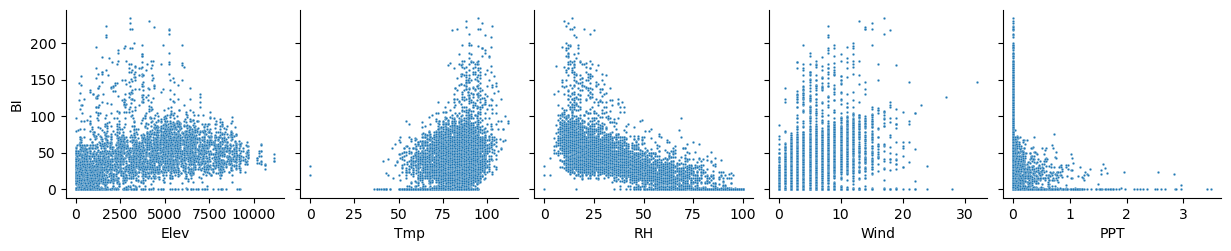

In [18]:
import seaborn as sns

sns.pairplot(longi_data_df,
            x_vars=["Elev", "Tmp", "RH","Wind","PPT"],
            y_vars=['BI'],plot_kws={"s": 3})

In [19]:
#longi_data_df = longi_data_df[longi_data_df['Tmp_standard']>-0.6]
outlier_stations = list(longi_data_df[longi_data_df['Tmp']<10]['Stn Name'].values)

# Drop pinehurts station
longi_data_df = longi_data_df[~longi_data_df['Stn Name'].isin(outlier_stations)]
station_info_df = station_info_df[~station_info_df['Stn Name'].isin(outlier_stations)]

Pre-processing - Normalize inputs to -1 - 1

In [20]:
import numpy as np

In [21]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler(feature_range=(-0.99, 0.99),copy=True, clip=False)

for s in ["Elev", "Tmp", "RH","Wind","PPT"]:
    scaler = MinMaxScaler(feature_range=(-1, 1),copy=True, clip=False)
    transformed_values = scaler.fit_transform(np.expand_dims(longi_data_df[s].values,1)).reshape(-1)
    
    longi_data_df[s+'_standard'] = transformed_values
    
scaler = StandardScaler(copy=True)
bi_transformed_values = scaler.fit_transform(np.expand_dims(longi_data_df['BI'].values,1)).reshape(-1)
longi_data_df['BI_standard'] = bi_transformed_values

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16904/1297636648.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longi_data_df[s+'_standard'] = transformed_values
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16904/1297636648.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longi_data_df[s+'_standard'] = transformed_values
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16904/1297636648.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [22]:
"""
#longi_data_df = longi_data_df[longi_data_df['Tmp_standard']>-0.6]
outlier_stations = list(longi_data_df[longi_data_df['Tmp_standard']<-0.6]['Stn Name'].values)

# Drop pinehurts station
longi_data_df = longi_data_df[~longi_data_df['Stn Name'].isin(outlier_stations)]
station_info_df = station_info_df[~station_info_df['Stn Name'].isin(outlier_stations)]
"""

"\n#longi_data_df = longi_data_df[longi_data_df['Tmp_standard']>-0.6]\noutlier_stations = list(longi_data_df[longi_data_df['Tmp_standard']<-0.6]['Stn Name'].values)\n\n# Drop pinehurts station\nlongi_data_df = longi_data_df[~longi_data_df['Stn Name'].isin(outlier_stations)]\nstation_info_df = station_info_df[~station_info_df['Stn Name'].isin(outlier_stations)]\n"

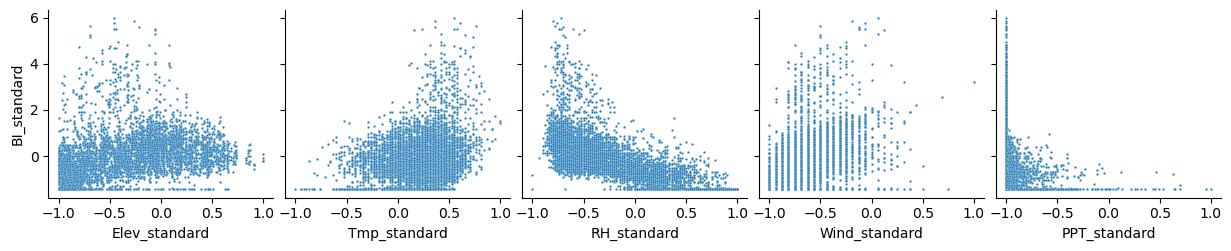

In [23]:
sns.pairplot(longi_data_df,
            x_vars=["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard","PPT_standard"],
            y_vars=['BI_standard'],plot_kws={"s": 3})

Plot on Map

## Fit Single QR Model First

- basically expand the panel dataset and treat it as cross section

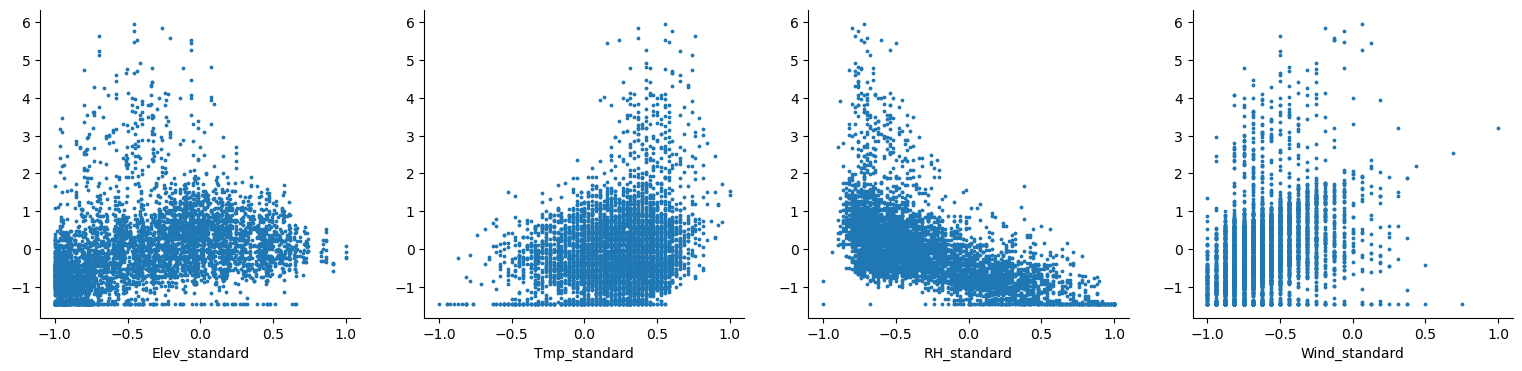

In [24]:
fig, ax = plt.subplots(1,4, figsize=(19,4))
for i,x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
    
    ax[i].scatter(longi_data_df[x_var_name],
                  longi_data_df['BI_standard'], s= 3)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xlabel(x_var_name)

In [25]:
import arviz as az
from Single_Var_QR import SingleQRSampler_T_4_block


Fit Multivariate model


In [71]:
np.random.seed(1234)

In [72]:
x_var = longi_data_df[["Elev_standard", "Tmp_standard",
                            "RH_standard","Wind_standard"]].values

In [73]:
x_var = longi_data_df[["Elev_standard", "Tmp_standard",
                            "RH_standard","Wind_standard"]].values
y_var = longi_data_df['BI_standard'].values


quantile_dist = 't'
prior_on_t = True

# Choose no. of chains
n_chains = 1
n_steps = 20000
n_burn_in = 5000

# Set Grid of tau values
tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)

data_size = len(x_var)
tau_upper_tail = 1-1/(2*data_size)
tau_lower_tail = 1/(2*data_size)
lower_seq = np.flip(geometric_seq(0.01, tau_lower_tail, 0.005, upper=False))
upper_seq = geometric_seq(0.99, tau_upper_tail, 0.005)

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])

# Run Sampler
sampler_collecter_4blockt = [SingleQRSampler_T_4_block(y_var,
                                    x_var,          
                                    C_1 = 0.3,
                                    lambda_step_size_1 = 3,
                                    alpha_step_size_1 = 0.4,
                                    a_target_1 = 0.228,
                                    C_2 = 0.3,
                                    lambda_step_size_2 = 3,
                                    alpha_step_size_2 = 0.4,
                                    a_target_2 = 0.228,
                                    C_3 = 0.5,
                                    lambda_step_size_3 = 3,
                                    alpha_step_size_3 = 0.4,
                                    a_target_3 = 0.228,
                                    C_4 = 0.3,
                                    lambda_step_size_4 = 3,
                                    alpha_step_size_4 = 0.4,
                                    a_target_4 = 0.228,
                                    tau_grid_expanded = tau_grid_expanded,
                                    tau_grid = tau_grid,     
                                    knot_points_grid = knot_points_grid,
                                    am_lamb_block1_init = 2*(2.38**2)/(9),
                                    am_lamb_block2_init = 2*(2.38**2)/(9),
                                    am_lamb_block3_init = 2*(2.38**2)/(4 + 4 + 4),
                                    am_lamb_block4_init = 2*(2.38**2)/(9*2+4 + 4 + 4),
                                    alpha_kappa = 0.1,
                                    beta_kappa = 0.1,
                                    eps_1 = 0,
                                    eps_2 = 0,
                                    base_quantile_mean=0.0,
                                    base_quantile_sd=1.0,
                                    base_quantile_v=1.0,
                                    base_quantile_dist=quantile_dist,
                                    prior_on_t=prior_on_t,
                                    verbose=False,
                                    splice=True,
                                    track_block=True) for _ in range(n_chains)]

chain_outputs = [sampler_c.sample(n_steps=n_steps) for sampler_c in sampler_collecter_4blockt]

sampler_collecter = sampler_collecter_4blockt


Multivariate model
Track Block:  True
Step:  0  Time Taken:  5.573045015335083
Step:  5000  Time Taken:  137.87608218193054
Step:  10000  Time Taken:  135.9377248287201
Step:  15000  Time Taken:  137.28217720985413


In [74]:
from Single_Var_QR_utils import generate_beta_samples_multivar

In [75]:
len(tau_grid)

113

In [40]:
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])



b1_val_means = []
b1_lo_cis = []
b1_hi_cis = []
i=0
for a,sq in enumerate(tau_grid):
    
    output_samps = generate_beta_samples_multivar(tau_input=sq,
                                                tau_grid=tau_grid_expanded,
                                                w_approx_store=chain_outputs[i]['w'],
                                                mu_store=chain_outputs[i]['mu'],
                                                gamma_store=chain_outputs[i]['gamma'],
                                                sigma_1_store=chain_outputs[i]['sigma_1'],
                                                sigma_2_store=chain_outputs[i]['sigma_2'],
                                                X_alpha_store = chain_outputs[i]['X_alpha'],
                                                base_quantile_dist=quantile_dist,
                                                v_store=chain_outputs[i]['v'],
                                                X_vals=x_var)
    
    output_samps = np.vstack(output_samps)[n_burn_in:]
    b1_sq_mean_values = []
    b1_lo_ci_values = []
    b1_hi_ci_values = []
    for j in range(4):
        
        b1_i_sq_samps = output_samps[:,j]
        b1_i_sq_mean = np.mean(b1_i_sq_samps)
        b1_i_sq_lo_ci, b1_i_sq_hi_ci = az.hdi(b1_i_sq_samps)
        
        b1_sq_mean_values.append(b1_i_sq_mean)
        b1_lo_ci_values.append(b1_i_sq_lo_ci)
        b1_hi_ci_values.append(b1_i_sq_hi_ci)
        
        
    b1_val_means.append(np.array(b1_sq_mean_values))
    b1_lo_cis.append(np.array(b1_lo_ci_values))
    b1_hi_cis.append(np.array(b1_hi_ci_values))
    
    print(a,'/',len(tau_grid))

b1_val_means = np.vstack(b1_val_means)
b1_lo_cis = np.vstack(b1_lo_cis)
b1_hi_cis = np.vstack(b1_hi_cis)

0 / 113
1 / 113
2 / 113
3 / 113
4 / 113
5 / 113
6 / 113
7 / 113
8 / 113
9 / 113
10 / 113
11 / 113
12 / 113
13 / 113
14 / 113
15 / 113
16 / 113
17 / 113
18 / 113
19 / 113
20 / 113
21 / 113
22 / 113
23 / 113
24 / 113
25 / 113
26 / 113
27 / 113
28 / 113
29 / 113
30 / 113
31 / 113
32 / 113
33 / 113
34 / 113
35 / 113
36 / 113
37 / 113
38 / 113
39 / 113
40 / 113
41 / 113
42 / 113
43 / 113
44 / 113
45 / 113
46 / 113
47 / 113
48 / 113
49 / 113
50 / 113
51 / 113
52 / 113
53 / 113
54 / 113
55 / 113
56 / 113
57 / 113
58 / 113
59 / 113
60 / 113
61 / 113
62 / 113
63 / 113
64 / 113
65 / 113
66 / 113
67 / 113
68 / 113
69 / 113
70 / 113
71 / 113
72 / 113
73 / 113
74 / 113
75 / 113
76 / 113
77 / 113
78 / 113
79 / 113
80 / 113
81 / 113
82 / 113
83 / 113
84 / 113
85 / 113
86 / 113
87 / 113
88 / 113
89 / 113
90 / 113
91 / 113
92 / 113
93 / 113
94 / 113
95 / 113
96 / 113
97 / 113
98 / 113
99 / 113
100 / 113
101 / 113
102 / 113
103 / 113
104 / 113
105 / 113
106 / 113
107 / 113
108 / 113
109 / 113
110 / 113


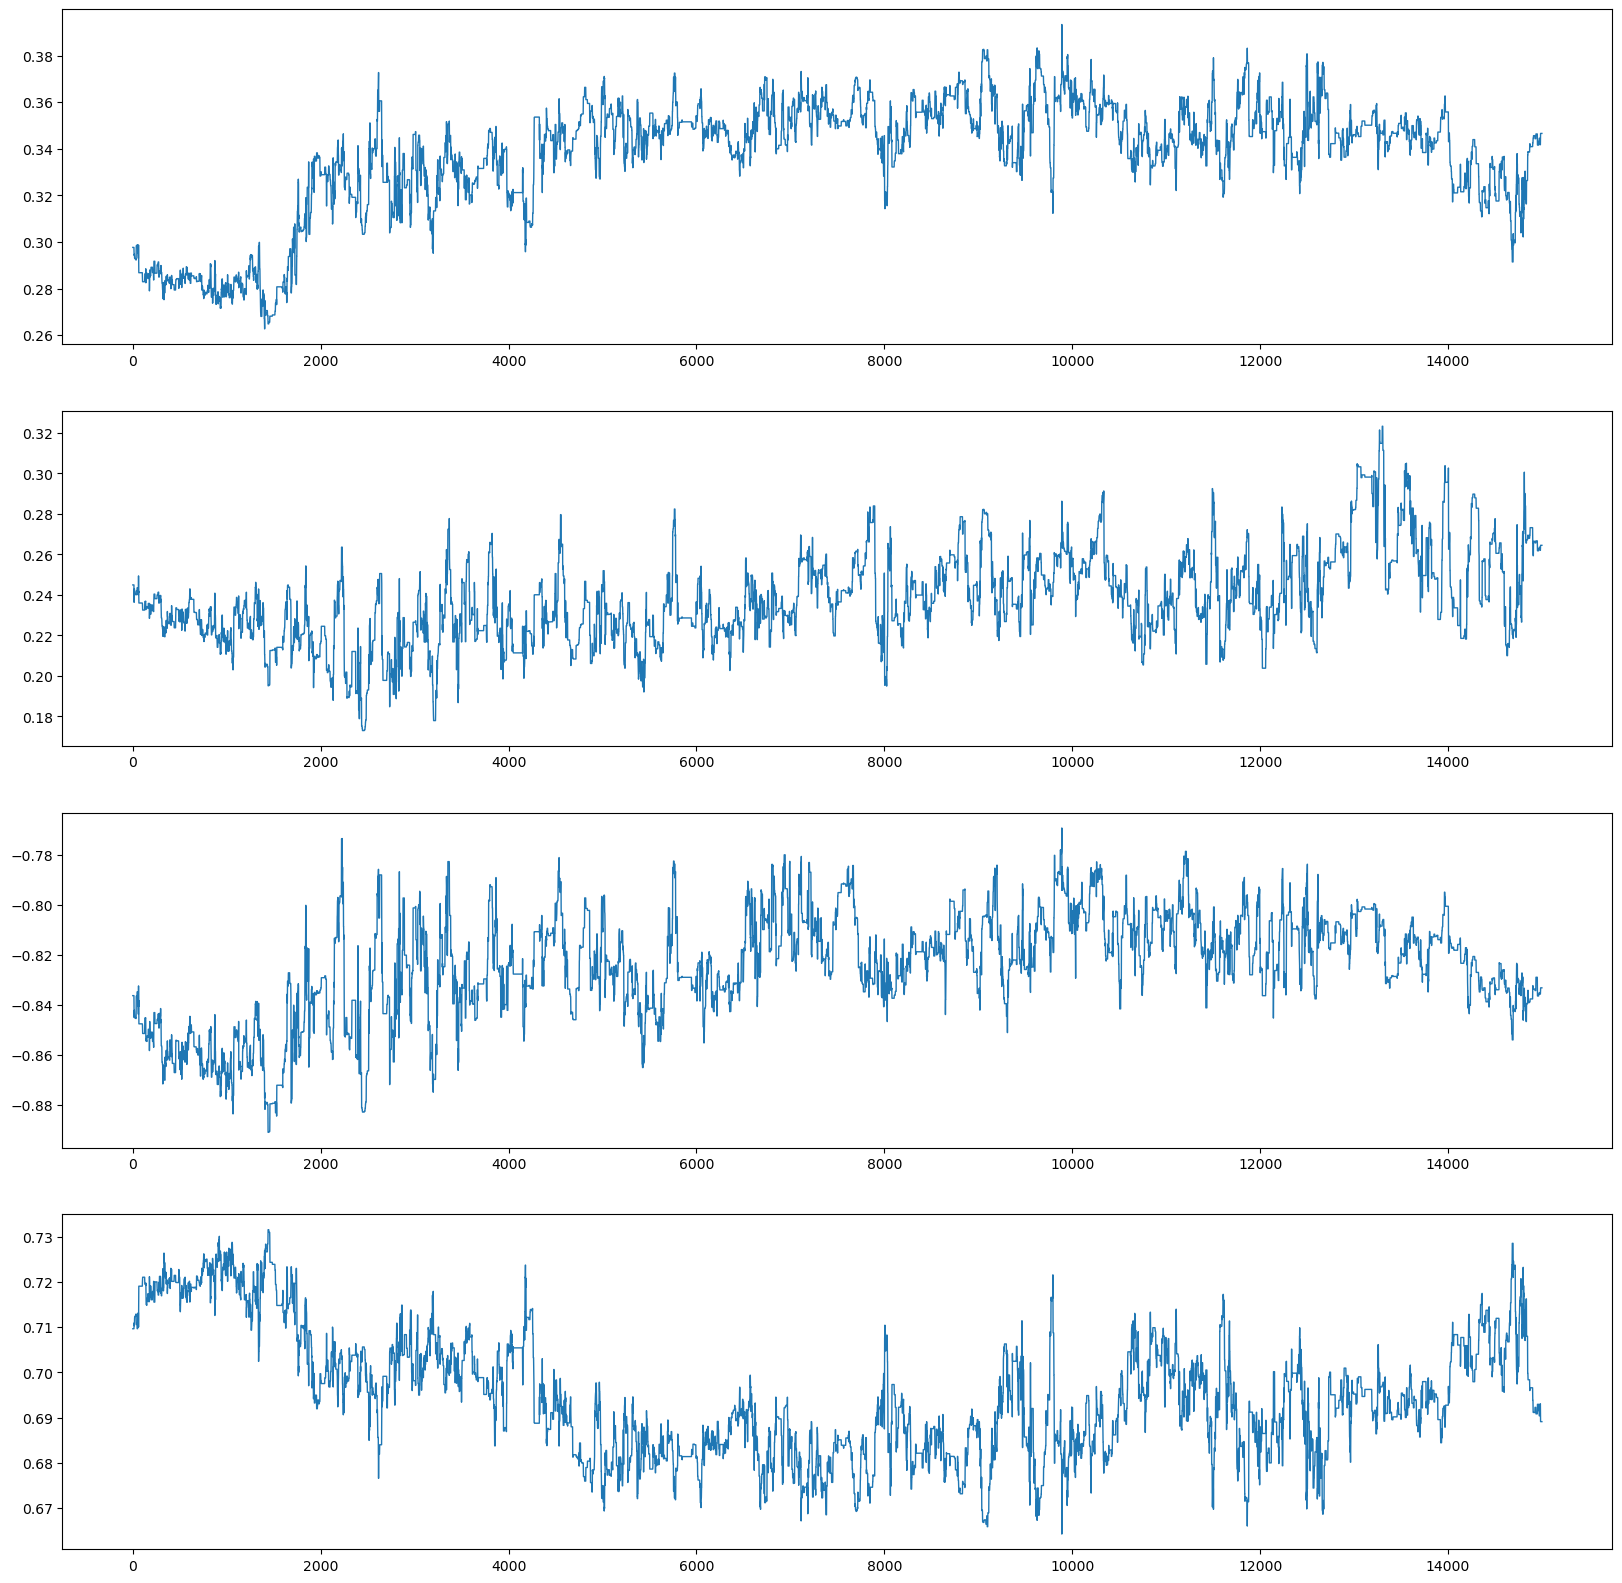

In [43]:
i=0
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])
output_samps = generate_beta_samples_multivar(tau_input=tau_grid[50],
                                            tau_grid=tau_grid_expanded,
                                            w_approx_store=chain_outputs[i]['w'],
                                            mu_store=chain_outputs[i]['mu'],
                                            gamma_store=chain_outputs[i]['gamma'],
                                            sigma_1_store=chain_outputs[i]['sigma_1'],
                                            sigma_2_store=chain_outputs[i]['sigma_2'],
                                            X_alpha_store = chain_outputs[i]['X_alpha'],
                                            base_quantile_dist=quantile_dist,
                                            v_store=chain_outputs[i]['v'],
                                            X_vals=x_var)
output_samps = np.vstack(output_samps)[n_burn_in:]

fig,ax = plt.subplots(4,1,figsize=(20,20))
for i in range(4):
    ax[i].plot(output_samps[:,i],lw=1)

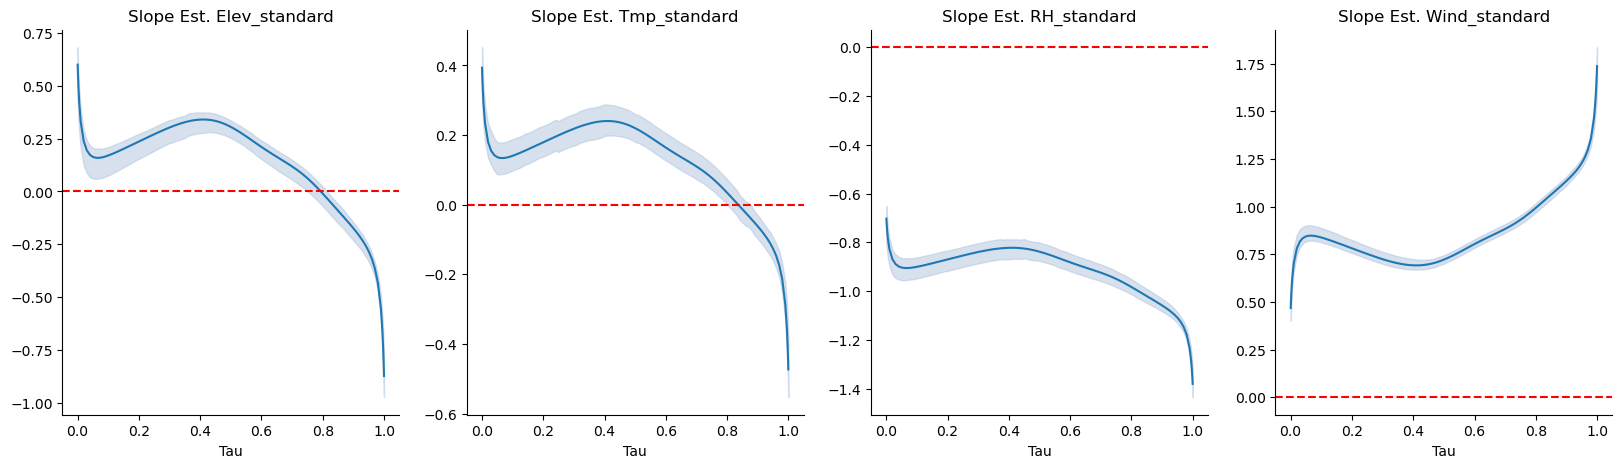

In [44]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for i,covar_name in enumerate(["Elev_standard", "Tmp_standard",
                            "RH_standard","Wind_standard"]):
    
    covar_means = b1_val_means[:,i]
    covar_lo_ci = b1_lo_cis[:,i]
    covar_hi_ci = b1_hi_cis[:,i]
    
    ax[i].plot(tau_grid,covar_means,color='tab:blue')
    ax[i].fill_between(tau_grid, covar_lo_ci,
                covar_hi_ci, color='lightsteelblue', alpha=.5)
    ax[i].axhline(0,color='red',linestyle='--')
    
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xlabel('Tau')
    ax[i].title.set_text(f"Slope Est. {covar_name}")
    
plt.savefig('Exp Results/Xu Dataset/Longi Run 1/Non Mixture Fit.png')


### Next Fit Mixture QR Models

In [26]:
np.random.seed(1234)

In [27]:
from epa import *

In [28]:
from geopy.distance import geodesic

def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

In [29]:
# Fix longitude
longi_data_df['Long_adj'] = -1*np.abs(longi_data_df['Long'])
station_info_df['Long_adj'] = -1*np.abs(station_info_df['Long'])

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16904/3712405274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longi_data_df['Long_adj'] = -1*np.abs(longi_data_df['Long'])


#### Design X and y Var 

- X: N(No. Stations) x Covar Id x No. Time Points
- Y: N(no. stations) x No. Time Points

In [30]:
n_stations = len(station_info_df)
n_covar = 4 
n_time_points = len(longi_data_df['Extract Year'].unique())

station_ids = station_info_df['Stn ID'].values
time_ids = np.sort(longi_data_df['Extract Year'].unique())
covar_ids = ["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]

assert(len(station_ids)==n_stations)
assert(len(time_ids) == n_time_points)

x_var_longi = np.zeros([n_stations, n_covar, n_time_points])
y_long = np.zeros([n_stations, n_time_points])
z_lon = np.zeros([n_stations])
z_lat = np.zeros([n_stations])
z_lon_alt = np.zeros([n_stations])
# Populate x_var_longi and y_longi

for i in range(len(station_ids)):

    z_lat_i = station_info_df[station_info_df['Stn ID']==station_ids[i]]['Lat'][0]
    z_lon_i = station_info_df[station_info_df['Stn ID']==station_ids[i]]['Long_adj'][0]
    z_lon_alt_i = station_info_df[station_info_df['Stn ID']==station_ids[i]]['Long'][0]
    
    z_lat[i] = z_lat_i
    z_lon[i] = z_lon_i
    z_lon_alt[i] = z_lon_alt_i
    
    for j in range(len(time_ids)):
        for k in range(len(covar_ids)):
            
            x_val = longi_data_df[(longi_data_df['Stn ID']==station_ids[i])&
             (longi_data_df['Extract Year']==time_ids[j])][covar_ids[k]].iloc[0]
            
            y_val = longi_data_df[(longi_data_df['Stn ID']==station_ids[i])&
             (longi_data_df['Extract Year']==time_ids[j])]['BI_standard'].iloc[0]
            
            x_var_longi[i,k,j] = x_val
            y_long[i,j] = y_val

Create distance matrix

In [31]:
num_points = len(z_lat)
distance_matrix = np.zeros((num_points, num_points))
distance_matrix_alt = np.zeros((num_points, num_points))

for i in range(num_points):
    for j in range(num_points):
        distance_matrix[i, j] = haversine(z_lat[i], z_lon[i], z_lat[j], z_lon[j])
        distance_matrix_alt[i, j] = haversine(z_lat[i], z_lon_alt[i], z_lat[j], z_lon_alt[j])


In [32]:
# Convert to similarity matrix
d_norm = distance_matrix/np.max(distance_matrix)
sim_mat = 1-d_norm + 0.01

d_norm_alt = distance_matrix_alt/np.max(distance_matrix_alt)
sim_mat_alt = 1-d_norm_alt + 0.01

Do Agglo Clustering on Distance Matrix First

In [33]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering(n_clusters=3, linkage='average')
agglo_pre_clusters = clustering.fit_predict(sim_mat)

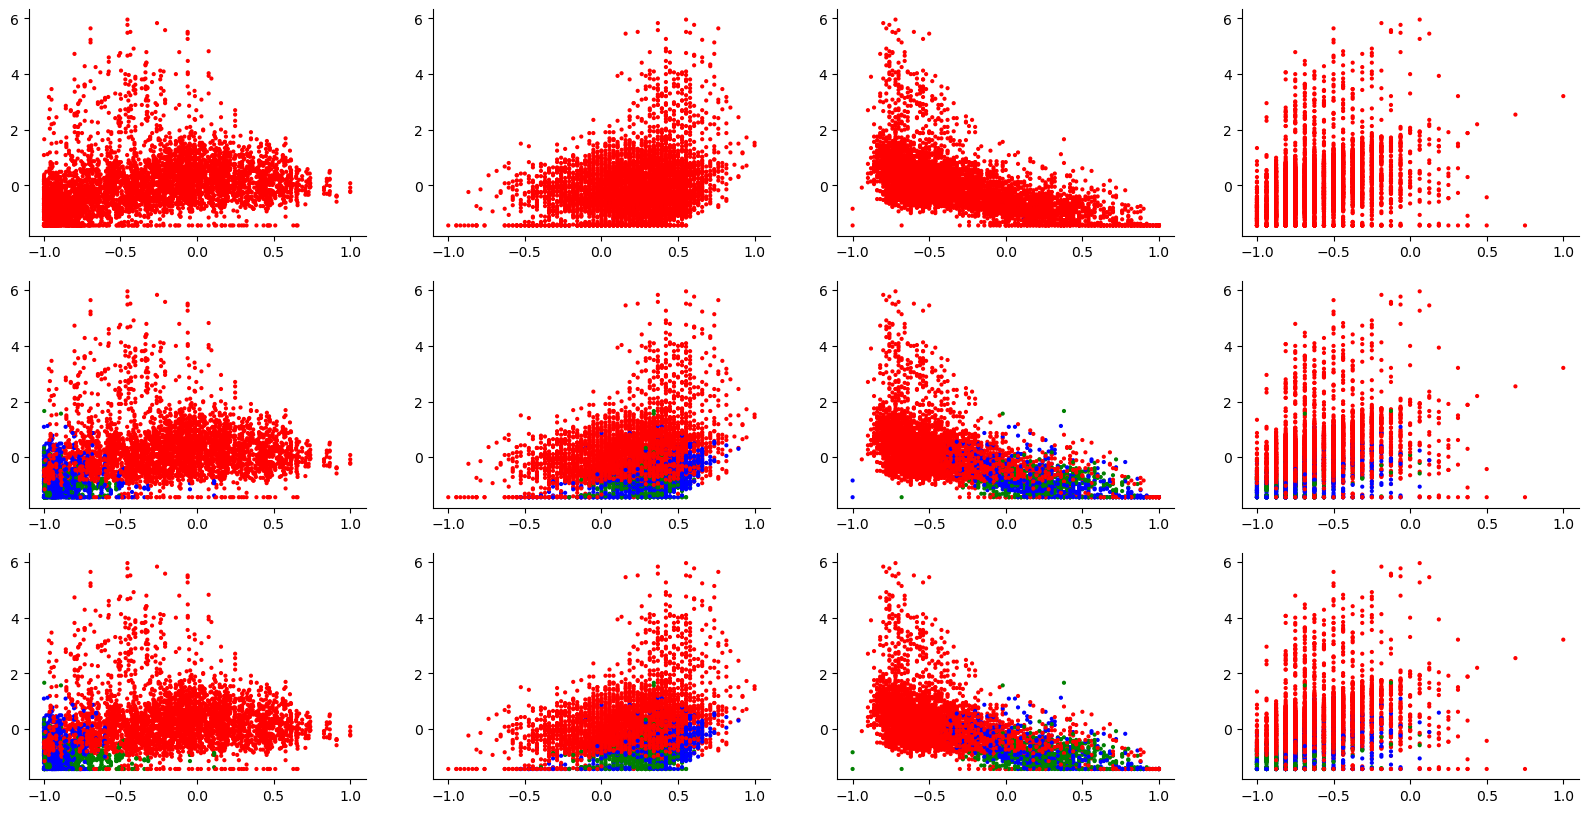

In [34]:
fig,ax = plt.subplots(3,4,figsize=(20,10))
agglo_cols = ['red','blue','green']

for ax_id_row, c_type in enumerate(['single','complete','average']):
    
    clustering = AgglomerativeClustering(n_clusters=3, linkage=c_type)
    agglo_pre_clusters = clustering.fit_predict(sim_mat)
    agglo_pre_clusters_rep = np.tile(agglo_pre_clusters[:, np.newaxis], (1, n_time_points))
    
    for ax_id_col, x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]): 
        
        x_vals_plot = x_var_longi[:,ax_id_col,:].reshape(-1)
        y_vals_plot = y_long.reshape(-1)
        agglo_clust_plot = agglo_pre_clusters_rep.reshape(-1)
        
        ax[ax_id_row, ax_id_col].scatter(x=x_vals_plot,
                   y=y_vals_plot, s=4,
                  color=[agglo_cols[i] for i in agglo_clust_plot])
        
        ax[ax_id_row, ax_id_col].spines[['right', 'top']].set_visible(False)


In [35]:
station_info_df.head()

Stn ID        Stn Name   Lat  Long    State  Long_adj
0   12302  TERRAPIN CREEK  33.8 -85.5  Alabama     -85.5
0   12701          TALLGA  33.4  86.0  Alabama     -86.0
0   12801     SCHOOLHOUSE  33.1  86.0  Alabama     -86.0
0   12902     SHOAL CREEK  33.6  85.6  Alabama     -85.6
0   13201       OAKMULGEE  32.9  87.1  Alabama     -87.1

In [39]:
color_dict_map

{'C0': 'red',
 'C1': 'blue',
 'C2': 'green',
 'C3': 'darkorange',
 'C4': 'black',
 'C5': 'purple',
 'C6': 'brown'}

In [41]:
station_info_df

Stn ID        Stn Name   Lat   Long    State  Long_adj Agglo_clusters
0    12302  TERRAPIN CREEK  33.8  -85.5  Alabama     -85.5             C2
0    12701          TALLGA  33.4   86.0  Alabama     -86.0             C2
0    12801     SCHOOLHOUSE  33.1   86.0  Alabama     -86.0             C2
0    12902     SHOAL CREEK  33.6   85.6  Alabama     -85.6             C2
0    13201       OAKMULGEE  32.9   87.1  Alabama     -87.1             C2
..     ...             ...   ...    ...      ...       ...            ...
0   482012  SANDSTONE RAWS  41.1  107.2  Wyoming    -107.2             C0
0   482102      ESTERBROOK  42.4  105.3  Wyoming    -105.3             C0
0   482105    SAWMILL PARK  41.0  106.1  Wyoming    -106.1             C0
0   482106     DODGE CREEK  41.9  105.5  Wyoming    -105.5             C0
0   483101        GUERNSEY  42.3  104.8  Wyoming    -104.8             C0

[1324 rows x 7 columns]

In [43]:
import plotly.express as px

clustering = AgglomerativeClustering(n_clusters=3, linkage='average')
agglo_pre_clusters = clustering.fit_predict(sim_mat)
agglo_pre_clust_prefix = np.array(['C' + x for x in agglo_pre_clusters.astype('str')])
station_info_df['Agglo_clusters'] = agglo_pre_clust_prefix

color_list = ['red', 'blue', 'green', 'darkorange', 'black', 'purple', 'brown']
color_dict_map = {'C'+str(i): color_list[i] for i in range(len(color_list))}

#station_info_df['Agglo_clusters'] = agglo_pre_clusters


# Assuming wildfire_data_df_xu is your DataFrame
fig = px.scatter_geo(station_info_df, lat='Lat', lon='Long_adj',
                     color='Agglo_clusters',
                     color_discrete_map=color_dict_map,
                     hover_data=station_info_df.columns,
                     scope='usa')

fig.update_geos(showcountries=True, countrycolor="Black", 
                showsubunits=True, subunitcolor="Black")
fig.update_traces(marker=dict(size=4))  # Adjust the size as needed

fig.update_layout(title='Wildfire Data Map of the USA with State Boundaries',
                  geo=dict(showland=True, landcolor="whitesmoke"))

fig.show()


/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [65]:
print(len(agglo_pre_clusters))

1324


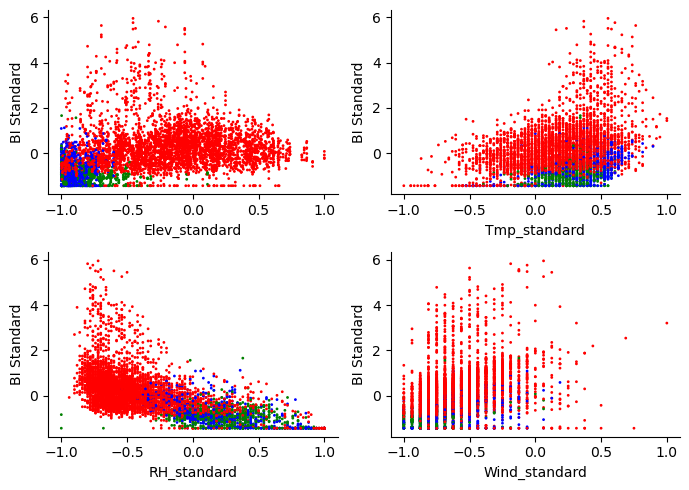

In [62]:
fig ,ax = plt.subplots(2,2, figsize=(7,5))
agglo_cols = ['red','blue','green']

c_type = 'average'
clustering = AgglomerativeClustering(n_clusters=3, linkage=c_type)
agglo_pre_clusters = clustering.fit_predict(sim_mat)
agglo_pre_clusters_rep = np.tile(agglo_pre_clusters[:, np.newaxis], (1, n_time_points))

col_pos_ids = [(0,0),(0,1),(1,0),(1,1)]

for ax_id_col, x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]): 

    x_vals_plot = x_var_longi[:,ax_id_col,:].reshape(-1)
    y_vals_plot = y_long.reshape(-1)
    agglo_clust_plot = agglo_pre_clusters_rep.reshape(-1)

    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].scatter(x=x_vals_plot,
               y=y_vals_plot, s=1,
              color=[agglo_cols[i] for i in agglo_clust_plot])

    ax[col_pos_ids[ax_id_col][0],
       col_pos_ids[ax_id_col][1]].spines[['right', 'top']].set_visible(False)
    
    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].set_xlabel(x_var_name)
    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].set_ylabel('BI Standard')
    
plt.tight_layout()
plt.savefig('Exp Results/Xu Dataset/Longi Run 1/Clustering_plot_pre_grid.png')
plt.savefig('Exp Results/Xu Dataset/Longi Run 2/Clustering_plot_pre_grid.png')

plt.show()

In [76]:
x_var_longi_alt = np.transpose(x_var_longi, (0,2,1))

In [77]:
Ys = y_long
Xs = x_var_longi_alt  # N x T x n_covar (Easier)

# Xs cross sectional rep
Xs_cross_sec = x_var_longi_alt.reshape(-1,n_covar)


if len(x_var.shape) > 1:
    multivariate_x = True
    n_covar = x_var.shape[1]
else:
    multivariate_x = False

if len(Ys.shape)>1:
    longi_x = True
else:
    longi_x = False

In [78]:
np.random.seed(1234)

In [79]:
start_time = time.time()

c1_params = chain_outputs[0]

lambda_init = 'tight' # 'standard'/'tight'

# similarity mat
tau = 2
#lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)
lambda_matrix = sim_mat

# Calc lambda

# intialize 
names_used = np.array([1,2])
alpha_samp = 1

# try with good distance function
#partition_samp = inds_train.copy()



# Scramble initialization after
partition_samp = np.array([1 if np.random.uniform(0,1)<0.5 else 2 for x in range(len(Xs))])  # try no initialization
partition_init  = partition_samp.astype('int')

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(len(Ys))
np.random.shuffle(order_samp)


#### gibbs sampling hyper parameters
n_gibbs = 2000
n_burn_in = 1000
k = 700 # no. of numbers to permute order
n_chain = 2

# GRW sampler param
rw_sd = 0.2

# alpha prior -> Want alpha to be small,  gammma prior so mean = a/b
a_alpha = 1
b_alpha = 2000
alpha_init = a_alpha/b_alpha
alpha_bounds = [0,1e99]

# delta prior -> Want delta to be smal lalso gammma prior so mean = a/b
a_delta = 1
b_delta = 2000
w_delta = 0.5
delta_bounds = [0,1]
delta_init = 0

# Tau prior
sample_tau = False
tau_bounds = [0,99]
a_tau = 4
b_tau = 2
tau_init = 1

labels_used = np.array([1,2])

reordering = True
use_split_merge_step = False


# phi sample - w1, w2, mu,gamma,sigma1,sigma2 - store as a vector

##############################
#### initialize QR Params ####
##############################
splice = True
m = 9

if multivariate_x:
    if not prior_on_t:
        phi_init = np.zeros([len(labels_used),
                        m+m+3+n_covar+n_covar]) # two GPs, mu,sigm1,sigma2, gamma (n_covar), x_alpha(n_covar)
    else:
        phi_init = np.zeros([len(labels_used),
                        m+m+4+n_covar + n_covar]) # Same as above but with v
else:
    if not prior_on_t:
        phi_init = np.zeros([len(labels_used), 
                        m+m+4])
    else:
        phi_init = np.zeros([len(labels_used),
                        m+m+5])

# Set tau grid
#tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
#tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)
m = len(knot_points_grid)

eta1_init = np.zeros([len(labels_used),
                     len(tau_grid)])
eta2_init = np.zeros([len(labels_used),
                     len(tau_grid)])
    
# Get lambda PDF
h=0.1
lambd_collect = calc_lambd_grid_uncorr(knot_points_grid.reshape(-1,1),
                                    h=h,
                                    rho_lambd_init=0.99)
lambd_grid = np.array(lambd_collect)
grid_pdf_vals = lamb_pdf(lambd_grid)
lambda_grid_log_prob = np.log(grid_pdf_vals)

#### Initialize Model Parameters
## GP Related hyperparameters
kappa_current = np.nan
rho_current = 0.1
lambd_current = 4
alpha_kappa = 3
beta_kappa = 1/3

## Regression related parametrs
mu_current = 0
gamma_current = 0
sigma_1_current = 1
sigma_2_current = 1


#### W samples 
# calc covariance matrix
cov_mat_knots_current = covariance_matrix_gp_uncorr(knot_points_grid.reshape(-1,1),
                                  lambd=lambd_current)
# Precompute Matrices
cov_matrices_G, A_matrices_G = precompute_approx_uncorr(tau_grid_expanded.reshape(-1,1),
                                                   knot_points_grid.reshape(-1,1),
                                                   lambda_grid=lambd_grid)

for j in range(len(labels_used)):
    
    # Initialise w1, w2 knots 
    w1_knot_points_current_j = np.array(c1_params['w1_knot'][n_steps-200:n_steps-1]).mean(0)

    w2_knot_points_current_j = np.array(c1_params['w2_knot'][n_steps-200:n_steps-1]).mean(0)

    
    remain_params_j = np.concatenate([np.array([np.array(c1_params['mu'][n_steps-200:n_steps-1]).mean(0)]),
                                      np.array(c1_params['gamma'][n_steps-200:n_steps-1]).mean(0),
                                      np.array([np.array(c1_params['sigma_1'][n_steps-200:n_steps-1]).mean(0),
                                                np.array(c1_params['sigma_2'][n_steps-200:n_steps-1]).mean(0)])])


    if prior_on_t:
        v_hat = np.array(c1_params['v'][n_steps-200:n_steps-1]).mean()
    else:
        v_hat=1.0
    
    
    if multivariate_x:
        X_alpha_current_j = np.array(c1_params['X_alpha'][n_steps-200:n_steps-1]).mean(0)

        if prior_on_t:
        # Store into phi_j
            phi_j = np.concatenate([w1_knot_points_current_j,
                                    w2_knot_points_current_j,
                                    remain_params_j, np.array([v_hat]),
                                    X_alpha_current_j])
        else:
            phi_j = np.concatenate([w1_knot_points_current_j,
                                w2_knot_points_current_j,
                                remain_params_j,
                                    X_alpha_current_j])
    else:
        X_alpha_current_j = None
        if prior_on_t:
        # Store into phi_j
            phi_j = np.concatenate([w1_knot_points_current_j,
                                    w2_knot_points_current_j,
                                    remain_params_j,
                                    np.array([v_hat])])
        else:
            phi_j = np.concatenate([w1_knot_points_current_j,
                                    w2_knot_points_current_j,
                                    remain_params_j])

    phi_init[j] = phi_j
    
    #### Get associated Quantile Function for each phi_j ####
    w1_knot_prop = w1_knot_points_current_j
    w2_knot_prop = w2_knot_points_current_j
    # Get approx
    w1_approx_prop_j, lp_w1_j = calc_mixture_knot_approx_marginalized(w1_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    
    w2_approx_prop_j, lp_w2_j = calc_mixture_knot_approx_marginalized(w2_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    # Get Q function
    mu_j, gamma_j, sigma1_j, sigma2_j = phi_j[18],phi_j[19],phi_j[20],phi_j[21]

    # get Eta functions
    eta_1_j  = eta_function_i_vector(tau_input=tau_grid,
                               w_vals=w1_approx_prop_j,
                               tau_grid=tau_grid_expanded,
                               mean=0.0,
                               sd=1.0,
                               v=v_hat,
                               sigma=sigma1_j,
                               dist=quantile_dist)

    eta_2_j  = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w2_approx_prop_j,
                           tau_grid=tau_grid_expanded,
                           mean=0.0,
                           sd=1.0,
                           v=v_hat,
                           sigma=sigma2_j,
                           dist=quantile_dist)

    eta1_init[j] = eta_1_j
    eta2_init[j] = eta_2_j

In [80]:
Ys = y_long
Xs = x_var_longi_alt  # N x T x n_covar (Easier)
Zs = None
sim_mat = sim_mat
partition_init = partition_init
phi_init = phi_init

tau_init =   tau_init
labels_used = labels_used
alpha_init = alpha_init
delta_init = delta_init
n_gibbs = n_gibbs
n_burn_in = n_burn_in
k = k
a_alpha = a_alpha
b_alpha = b_alpha
a_delta = a_delta
b_delta = b_delta
a_tau =  a_tau
b_tau =  b_tau
w_delta = 0.5
reordering = reordering
use_split_merge_step = use_split_merge_step
sample_tau = False

In [82]:
n = len(Ys)
# intialize 
names_used = labels_used
alpha_samp = alpha_init

delta_samp = delta_init
order_samp = np.arange(n)
np.random.shuffle(order_samp)

# initialize QR params
phi_samp = phi_init
eta1_samp = eta1_init
eta2_samp = eta2_init

partition_samp = partition_init
tau_samp = tau_init


#### gibbs sampling hyper parameters
n_gibbs = n_gibbs
k = k # no. of numbers to permute order

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = a_alpha
b_alpha = b_alpha
alpha_bounds = [0,1e99]

# delta prior
a_delta = a_delta
b_delta = b_delta

assert (w_delta<=1) and (w_delta>=0)
w_delta = w_delta
delta_bounds = [0,1]
tau_bounds = [0,1e99]


partition_save = []
alpha_save = []
delta_save = []
phi_save = []
log_prob_save = []
sigma_reg_save = []
tau_save = []

# Track acceptance rates
split_merge_accept_save = []
tau_accept_save = []
delta_accept_save = []
order_accept_save = []
alpha_accept_save = []


s1 = time.time()
# Gibbs loop
for g in range(n_gibbs+n_burn_in):
    if g%10 == 0:
        e1 = time.time()
        print("Gibbs: ", g, " Time Taken: ", (e1-s1)/60)
        print("Active No Clusters: ", len(np.unique(partition_samp)))
        print("Active No Clusters: ", pd.Series(partition_samp).value_counts())
        s1 = time.time()

    # Get last term in order samp
    #last_term_samp = order_samp[-1]
    last_term_id = order_samp[-1]#np.where(order_samp == np.max(order_samp))[0][0]

    #print('Partition Update')
    # Draw sample for the final term
    if prior_on_t:
        v_samp = phi_samp[-1]
    else:
        v_samp = 1.0
    
    partition_samp, phi_samp, names_used, \
        partition_factors, eta1_samp, eta2_samp = sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                    i=last_term_id,
                                    order_place=0,
                                    partition=partition_samp,
                                    return_fac=True,
                                    pre_compute_factors=np.zeros(1),
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    sim_mat=sim_mat,
                                    order=order_samp,
                                    phi=phi_samp,
                                    eta1_mat=eta1_samp, 
                                    eta2_mat=eta2_samp,
                                    y=Ys,
                                    x=Xs,
                                    A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                       w_cov_mat=cov_mat_knots_current,
                                      alpha_kappa=5,
                                      beta_kappa=1/3,
                                      tau_grid=tau_grid,
                                      tau_grid_expanded=tau_grid_expanded,
                                    base_quantile_mean=0.0,
                                     base_quantile_sd=1.0,
                                     base_quantile_v=v_samp,
                                     base_quantile_dist=quantile_dist,
                                    names_used=names_used,                      
                                    reordering=reordering,
                                    splice=splice,
                                    prior_on_t=prior_on_t,
                                        multivariate_x=multivariate_x,
                                    longi_x=longi_x)
    
    for o in list(range(len(order_samp)-2,-1,-1)):

        term_id = order_samp[o]#np.where(order_samp == o)[0][0]

        partition_samp, phi_samp, names_used,\
              eta1_samp, eta2_samp= sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                        i=term_id,
                                        order_place=o,
                                        partition=partition_samp,
                                        return_fac=False,
                                        pre_compute_factors=partition_factors,
                                        alpha=alpha_samp,
                                        delta=delta_samp,
                                        sim_mat=sim_mat,
                                        order=order_samp,
                                        phi=phi_samp,
                                        eta1_mat=eta1_samp, 
                                        eta2_mat=eta2_samp,
                                        y=Ys,
                                        x=Xs,
                                        A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                           w_cov_mat=cov_mat_knots_current,
                                          alpha_kappa=5,
                                          beta_kappa=1/3,
                                          tau_grid=tau_grid,
                                          tau_grid_expanded=tau_grid_expanded,
                                        base_quantile_mean=0.0,
                                         base_quantile_sd=1.0,
                                         base_quantile_v=v_samp,
                                         base_quantile_dist=quantile_dist,
                                        names_used=names_used,
                                        reordering=reordering,
                                            prior_on_t=prior_on_t,
                                            multivariate_x=multivariate_x,
                                        longi_x=longi_x)

    """
    if use_split_merge_step:
    #### Split Merge step ####
        partition_samp,phi_samp, names_used,\
        sigma2_reg_samp, accept_samp = split_merge_step(partition_samp=partition_samp,
                                                    alpha=alpha_samp,
                                                    delta=delta_samp,
                                                    sim_mat=sim_mat,
                                                    order=order_samp,
                                                    phi_samp=phi_samp,
                                                    y=Ys,
                                                    x=Xs, 
                                                    sigma2_reg_samp=sigma2_reg_samp,
                                                    v_0=v_0,
                                                    sigma2_0=sigma2_0,
                                                    names_used=names_used, 
                                                    phi_base_mean=phi_mean_prior,
                                                    phi_base_cov=phi_cov_prior,
                                                    no_intermediate_steps=5)

        if g>n_burn_in:

            split_merge_accept_save.append(accept_samp)
    """

    partition_samp = partition_samp.astype('int')

    
    #print("Sampling Phi")
    phi_samp, eta1_samp, eta2_samp = sample_phi_QR(phi_cur=phi_samp,
                           eta1_cur=eta1_samp,
                           eta2_cur=eta2_samp,
                           n_steps=200,
                           y=Ys,
                           x=Xs,
                            A_matrices_G = A_matrices_G,
                        cov_matrices_G = cov_matrices_G,
                        lambda_grid_log_prob= lambda_grid_log_prob,
                        cov_mat_knots_init=cov_mat_knots_current,
                           partition=partition_samp,
                          tau_grid=tau_grid,
                           tau_grid_expanded=tau_grid_expanded,
                           base_quantile_mean=0.0,
                           base_quantile_sd=1.0,
                           base_quantile_v=1.0,
                          base_quantile_dist=quantile_dist,
                          prior_on_t=prior_on_t,
                            longi_x=longi_x)

    # Sample ordering 
    #order_samp = permute_k(order_samp, k)
    #print("Sample Order")
    order_samp,order_accept_s = metropolis_step_order(order_current=order_samp,
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    partition=partition_samp,
                                    sim_mat=sim_mat,
                                    k=k)

    if g>n_burn_in:
        order_accept_save.append(order_accept_s)

    #### Sample parameters, alpha, sigma
    #print("Sampling Alpha")
    alpha_samp, alpha_accept_s = metropolis_step_alpha(alpha_samp,
                                                    rw_sd,
                                                    a_alpha, b_alpha,
                                                    partition_samp,
                                                        delta_samp,
                                                        sim_mat,
                                                        order_samp,
                                                    bounds=alpha_bounds)

    if g>n_burn_in:
        alpha_accept_save.append(alpha_accept_s)

    #print("Sampling Delta")
    delta_samp, delta_accept_s = metropolis_step_delta(delta_samp, rw_sd,
                                                    a_delta, b_delta, w_delta,
                                                    partition_samp,
                                                        alpha_samp,
                                                        sim_mat,
                                                        order_samp,bounds=delta_bounds)

    if g>n_burn_in:
        delta_accept_save.append(delta_accept_s)

    # Update Tau + Sim mat
    if sample_tau:
        tau_samp, sim_mat, tau_accept_s = metropolis_step_tau(tau_samp, rw_sd, a_tau, b_tau,
                            partition_samp,
                                alpha_samp,
                                delta_samp,
                                sim_mat,
                                X=Zs.reshape(-1,1),
                        order=order_samp,bounds=tau_bounds)

        if g>n_burn_in:
            tau_accept_save.append(tau_accept_s)

    """
    # Calc log prob of result
    log_prob_samp = calc_log_joint(partition=partition_samp,
                                phi=phi_samp,
                                y=Ys,
                                x=Xs,
                                sim_mat=sim_mat,
                                order=order_samp,
                                alpha=alpha_samp,
                                delta=delta_samp,
                                sigma_reg = sigma_reg)
    """

    if g>n_burn_in:

        # Save sampled values
        #log_prob_save.append(log_prob_samp)
        partition_save.append(partition_samp)
        alpha_save.append(alpha_samp)
        delta_save.append(delta_samp)
        phi_save.append(phi_samp)
        tau_save.append(tau_samp)


acceptance_rates = {'Split Merge': np.mean(split_merge_accept_save),
                    'Tau': np.mean(tau_accept_save),
                    'Delta': np.mean(delta_accept_save),
                    'Order': np.mean(order_accept_save),
                    'Alpha': np.mean(alpha_accept_save)}

acceptance_rates = pd.DataFrame.from_dict(acceptance_rates, orient='index')
acceptance_rates.columns=['Acceptance Rate']
acceptance_rates


Gibbs:  0  Time Taken:  6.651878356933593e-06
Active No Clusters:  2
Active No Clusters:  2    668
1    656
Name: count, dtype: int64


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Gibbs:  10  Time Taken:  3.6504607995351157
Active No Clusters:  2
Active No Clusters:  1    1182
2     142
Name: count, dtype: int64
Gibbs:  20  Time Taken:  3.2588668346405028
Active No Clusters:  2
Active No Clusters:  1    1208
2     116
Name: count, dtype: int64
Gibbs:  30  Time Taken:  3.9208868662516276
Active No Clusters:  3
Active No Clusters:  1    715
2    503
3    106
Name: count, dtype: int64
Gibbs:  40  Time Taken:  3.71720503171285
Active No Clusters:  3
Active No Clusters:  1    690
2    534
3    100
Name: count, dtype: int64
Gibbs:  50  Time Taken:  3.703363335132599
Active No Clusters:  3
Active No Clusters:  1    655
2    570
3     99
Name: count, dtype: int64
Gibbs:  60  Time Taken:  3.7759196639060972
Active No Clusters:  3
Active No Clusters:  1    693
2    535
3     96
Name: count, dtype: int64
Gibbs:  70  Time Taken:  3.6908915837605796
Active No Clusters:  3
Active No Clusters:  1    655
2    564
3    105
Name: count, dtype: int64
Gibbs:  80  Time Taken:  3.801

Gibbs:  510  Time Taken:  8.846526062488556
Active No Clusters:  9
Active No Clusters:  1    464
2    269
3    261
4    177
5     39
6     32
7     32
8     29
9     21
Name: count, dtype: int64
Gibbs:  520  Time Taken:  8.636620267232258
Active No Clusters:  10
Active No Clusters:  1     471
2     279
3     253
4     165
5      47
6      29
7      28
8      26
9      24
10      2
Name: count, dtype: int64
Gibbs:  530  Time Taken:  8.710074063142141
Active No Clusters:  9
Active No Clusters:  1    453
2    295
3    236
4    170
5     59
6     34
7     28
8     28
9     21
Name: count, dtype: int64
Gibbs:  540  Time Taken:  8.771329534053802
Active No Clusters:  9
Active No Clusters:  1    510
2    250
3    213
4    203
5     37
6     33
7     30
8     24
9     24
Name: count, dtype: int64
Gibbs:  550  Time Taken:  8.693924363454183
Active No Clusters:  9
Active No Clusters:  1    510
2    219
3    202
4    172
5     71
6     62
7     36
8     33
9     19
Name: count, dtype: int64
Gibbs

Gibbs:  920  Time Taken:  10.539342232545216
Active No Clusters:  11
Active No Clusters:  1     296
2     280
3     260
4     133
5     132
6     118
7      43
8      29
9      24
10      8
11      1
Name: count, dtype: int64
Gibbs:  930  Time Taken:  10.689395201206207
Active No Clusters:  10
Active No Clusters:  1     289
2     215
3     207
4     193
5     164
6     147
7      48
8      26
9      26
10      9
Name: count, dtype: int64
Gibbs:  940  Time Taken:  10.107108549276989
Active No Clusters:  10
Active No Clusters:  1     326
2     237
3     230
4     147
5     144
6     136
7      43
8      29
9      23
10      9
Name: count, dtype: int64
Gibbs:  950  Time Taken:  10.271135600407918
Active No Clusters:  11
Active No Clusters:  1     310
2     244
3     231
4     173
5     146
6     112
7      37
8      26
9      24
10     12
11      9
Name: count, dtype: int64
Gibbs:  960  Time Taken:  10.672513302167257
Active No Clusters:  11
Active No Clusters:  1     321
2     213
3     

Gibbs:  1300  Time Taken:  11.30457144578298
Active No Clusters:  11
Active No Clusters:  1     315
2     293
3     236
4     129
5     116
6     107
7      49
8      33
9      20
10     18
11      8
Name: count, dtype: int64
Gibbs:  1310  Time Taken:  11.889487767219544
Active No Clusters:  11
Active No Clusters:  1     325
2     316
3     179
4     139
5     118
6     114
7      56
8      37
9      21
10     15
11      4
Name: count, dtype: int64
Gibbs:  1320  Time Taken:  11.296243321895599
Active No Clusters:  11
Active No Clusters:  1     265
2     225
3     222
4     195
5     162
6     133
7      44
8      41
9      19
10     15
11      3
Name: count, dtype: int64
Gibbs:  1330  Time Taken:  12.519743283589682
Active No Clusters:  11
Active No Clusters:  1     312
2     271
3     238
4     131
5     115
6     112
7      67
8      33
9      20
10     18
11      7
Name: count, dtype: int64
Gibbs:  1340  Time Taken:  10.825642601648967
Active No Clusters:  11
Active No Clusters:  1 

Gibbs:  1670  Time Taken:  10.79824108282725
Active No Clusters:  11
Active No Clusters:  1     367
2     214
3     201
4     195
5     127
6      84
7      60
8      24
9      21
10     19
11     12
Name: count, dtype: int64
Gibbs:  1680  Time Taken:  10.727227830886841
Active No Clusters:  11
Active No Clusters:  1     400
2     253
3     216
4     168
5     124
6      44
7      43
8      31
9      18
10     16
11     11
Name: count, dtype: int64
Gibbs:  1690  Time Taken:  10.671559369564056
Active No Clusters:  11
Active No Clusters:  1     361
2     237
3     230
4     180
5     112
6      82
7      41
8      26
9      21
10     19
11     15
Name: count, dtype: int64
Gibbs:  1700  Time Taken:  11.334106214841206
Active No Clusters:  12
Active No Clusters:  1     328
2     236
3     218
4     206
5     125
6      90
7      38
8      26
9      23
10     20
11      9
12      5
Name: count, dtype: int64
Gibbs:  1710  Time Taken:  11.480221219857533
Active No Clusters:  12
Active No Clu

Gibbs:  2040  Time Taken:  10.67239963610967
Active No Clusters:  11
Active No Clusters:  1     379
2     256
3     230
4     173
5     105
6      53
7      51
8      32
9      19
10     15
11     11
Name: count, dtype: int64
Gibbs:  2050  Time Taken:  10.716028400262196
Active No Clusters:  11
Active No Clusters:  1     344
2     232
3     219
4     203
5     114
6      92
7      45
8      32
9      23
10     11
11      9
Name: count, dtype: int64
Gibbs:  2060  Time Taken:  11.373829797903698
Active No Clusters:  11
Active No Clusters:  1     359
2     275
3     208
4     162
5     120
6      73
7      52
8      29
9      18
10     17
11     11
Name: count, dtype: int64
Gibbs:  2070  Time Taken:  11.339661435286205
Active No Clusters:  11
Active No Clusters:  1     363
2     268
3     209
4     202
5     100
6      60
7      41
8      34
9      19
10     17
11     11
Name: count, dtype: int64
Gibbs:  2080  Time Taken:  11.343895018100739
Active No Clusters:  11
Active No Clusters:  1 

Gibbs:  2400  Time Taken:  11.407684763272604
Active No Clusters:  11
Active No Clusters:  1     300
2     287
3     234
4     145
5     139
6     103
7      32
8      28
9      24
10     20
11     12
Name: count, dtype: int64
Gibbs:  2410  Time Taken:  11.344381431738535
Active No Clusters:  11
Active No Clusters:  1     327
2     274
3     210
4     168
5     123
6     107
7      28
8      27
9      26
10     21
11     13
Name: count, dtype: int64
Gibbs:  2420  Time Taken:  11.600388618310292
Active No Clusters:  11
Active No Clusters:  1     323
2     286
3     204
4     166
5     123
6     109
7      30
8      25
9      21
10     19
11     18
Name: count, dtype: int64
Gibbs:  2430  Time Taken:  12.076762727896373
Active No Clusters:  11
Active No Clusters:  1     386
2     284
3     203
4     173
5     101
6      64
7      32
8      27
9      24
10     19
11     11
Name: count, dtype: int64
Gibbs:  2440  Time Taken:  11.392760062217713
Active No Clusters:  11
Active No Clusters:  1

Gibbs:  2760  Time Taken:  11.622928980986277
Active No Clusters:  12
Active No Clusters:  1     340
2     280
3     226
4     149
5     114
6     100
7      25
8      23
9      21
10     18
11     16
12     12
Name: count, dtype: int64
Gibbs:  2770  Time Taken:  11.70381407737732
Active No Clusters:  12
Active No Clusters:  1     293
2     252
3     249
4     180
5     129
6     102
7      42
8      22
9      17
10     16
11     13
12      9
Name: count, dtype: int64
Gibbs:  2780  Time Taken:  11.860949365297953
Active No Clusters:  12
Active No Clusters:  1     335
2     276
3     204
4     179
5     115
6     104
7      33
8      20
9      19
10     16
11     13
12     10
Name: count, dtype: int64
Gibbs:  2790  Time Taken:  12.368103500207265
Active No Clusters:  12
Active No Clusters:  1     308
2     287
3     215
4     196
5     116
6      87
7      37
8      20
9      18
10     17
11     16
12      7
Name: count, dtype: int64
Gibbs:  2800  Time Taken:  12.73383853038152
Active N

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



Acceptance Rate
Split Merge              NaN
Tau                      NaN
Delta               0.000000
Order               0.025013
Alpha               0.012506

Save everything

In [67]:
"""
import pickle

# Define the file path
file_path = 'Exp Results/Xu Dataset/Longi Run 1/'

# Pickle partition_save
with open(file_path + 'partition_save.pkl', 'wb') as f:
    pickle.dump(partition_save, f)

# Pickle alpha_save
with open(file_path + 'alpha_save.pkl', 'wb') as f:
    pickle.dump(alpha_save, f)

# Pickle delta_save
with open(file_path + 'delta_save.pkl', 'wb') as f:
    pickle.dump(delta_save, f)

# Pickle phi_save
with open(file_path + 'phi_save.pkl', 'wb') as f:
    pickle.dump(phi_save, f)

# Pickle tau_save
with open(file_path + 'tau_save.pkl', 'wb') as f:
    pickle.dump(tau_save, f)
"""

"\nimport pickle\n\n# Define the file path\nfile_path = 'Exp Results/Xu Dataset/Longi Run 1/'\n\n# Pickle partition_save\nwith open(file_path + 'partition_save.pkl', 'wb') as f:\n    pickle.dump(partition_save, f)\n\n# Pickle alpha_save\nwith open(file_path + 'alpha_save.pkl', 'wb') as f:\n    pickle.dump(alpha_save, f)\n\n# Pickle delta_save\nwith open(file_path + 'delta_save.pkl', 'wb') as f:\n    pickle.dump(delta_save, f)\n\n# Pickle phi_save\nwith open(file_path + 'phi_save.pkl', 'wb') as f:\n    pickle.dump(phi_save, f)\n\n# Pickle tau_save\nwith open(file_path + 'tau_save.pkl', 'wb') as f:\n    pickle.dump(tau_save, f)\n"

In [84]:
import pickle

# Define the file path
file_path = 'Exp Results/Xu Dataset/Longi Run 1/'

# Load partition_save
with open(file_path + 'partition_save.pkl', 'rb') as f:
    partition_save = pickle.load(f)

# Load phi_save
with open(file_path + 'phi_save.pkl', 'rb') as f:
    phi_save = pickle.load(f)

print("Arrays loaded successfully.")


Arrays loaded successfully.



Get clustering matrix

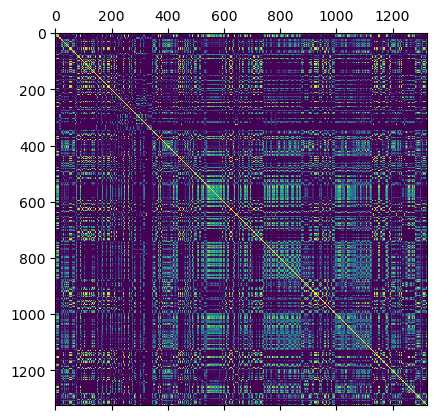

In [85]:
cluster_size_samples = np.array([len(np.unique(p)) for p in partition_save])
np.mean(cluster_size_samples)


normalized_sim_mat = calc_hit_matrix(partition_save,
                                     burn_samples=0,
                                     normalize=True)

plt.matshow(normalized_sim_mat)
plt.show()

In [86]:
np.mean(cluster_size_samples)


11.105052526263131

In [112]:
partition_save[0]

array([4, 4, 3, ..., 4, 1, 5])

### Plot Clusters

- Note X: n X T x p

In [87]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=3,
                                       linkage_type='complete')

agglo_cluster_solution_rep = np.tile(agglo_cluster_solution[:, np.newaxis], (1, n_time_points))


/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



In [88]:
pd.Series(agglo_cluster_solution).value_counts()

0    686
1    452
2    186
Name: count, dtype: int64

In [89]:
agglo_cols = ['red', 'blue', 'green', 'darkorange', 'black', 'purple', 'brown', 'grey']

In [90]:
agglo_cluster_solution_rep.shape

(1324, 4)

In [91]:
x_var_longi.shape

(1324, 4, 4)

In [92]:
# 5 clust - average linkage - good

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



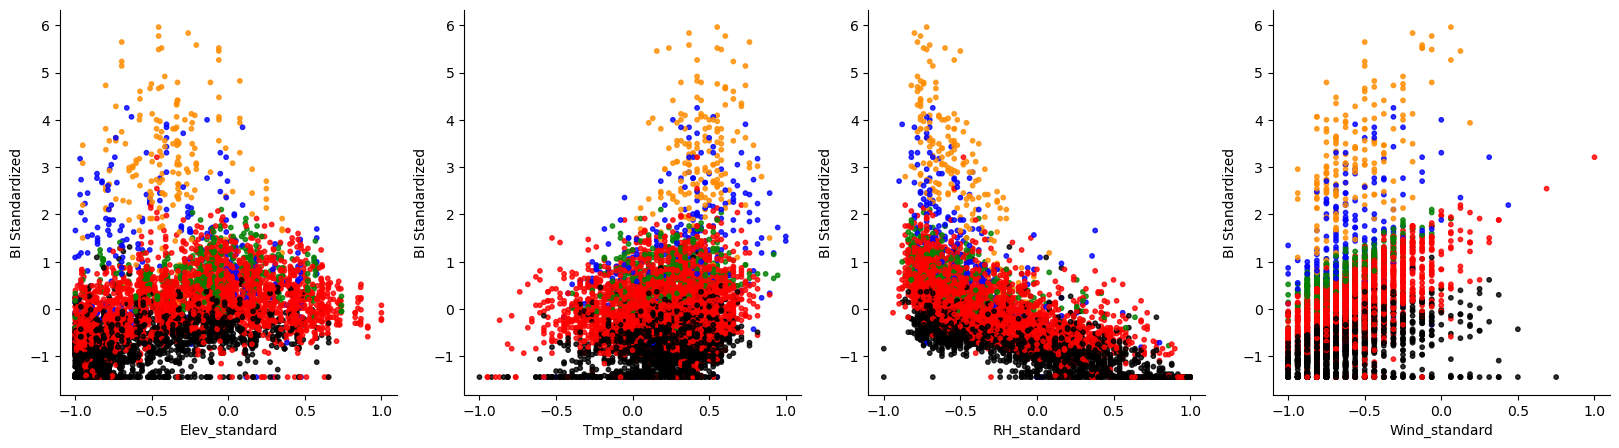

In [108]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=5,
                                       linkage_type='average')

agglo_cluster_solution_rep = np.tile(agglo_cluster_solution[:, np.newaxis], (1, n_time_points))


fig, ax = plt.subplots(1,4,figsize=(20,5))

for j,covar_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
    
    x_vals_plot = Xs[:,:,j].reshape(-1)
    y_vals_plot = y_long.reshape(-1)
    agglo_clust_plot = agglo_cluster_solution_rep.reshape(-1)

    
    ax[j].scatter(x_vals_plot, y_vals_plot,
                s=10,
               color=[agglo_cols[i] for i in agglo_clust_plot], alpha=0.8)

    ax[j].set_xlabel(covar_name)
    ax[j].set_ylabel('BI Standardized')
    ax[j].spines[['right', 'top']].set_visible(False)
plt.savefig('Exp Results/Xu Dataset/Longi Run 1/Clustering_plot.png')

plt.show()


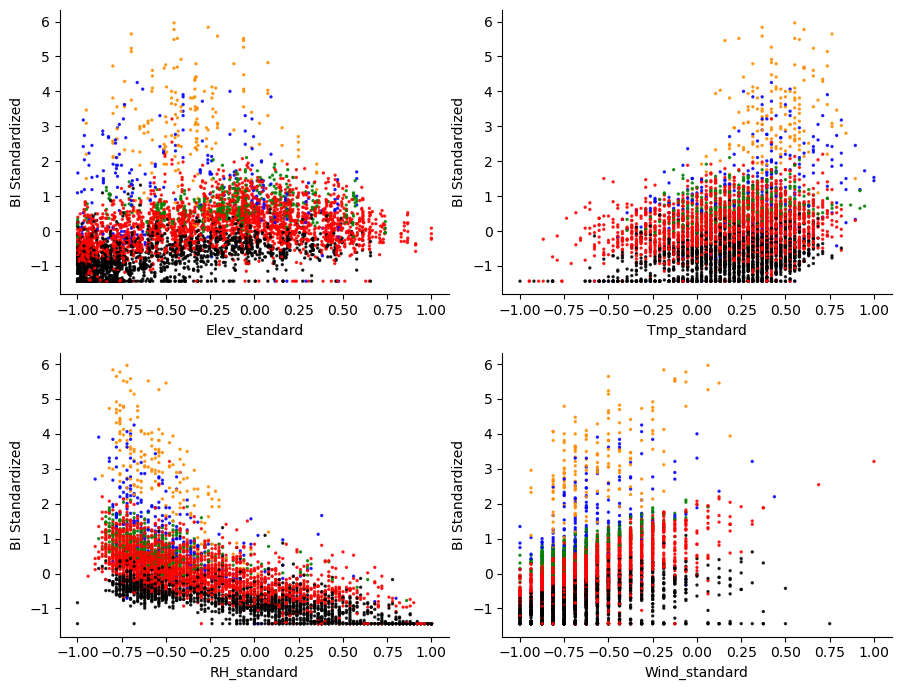

In [110]:
fig ,ax = plt.subplots(2,2, figsize=(9,7))
col_pos_ids = [(0,0),(0,1),(1,0),(1,1)]

for j,covar_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
    
    x_vals_plot = Xs[:,:,j].reshape(-1)
    y_vals_plot = y_long.reshape(-1)
    agglo_clust_plot = agglo_cluster_solution_rep.reshape(-1)

    
    ax[col_pos_ids[j][0], col_pos_ids[j][1]].scatter(x_vals_plot, y_vals_plot,
                s=2,
               color=[agglo_cols[i] for i in agglo_clust_plot], alpha=0.8)

    ax[col_pos_ids[j][0], col_pos_ids[j][1]].set_xlabel(covar_name)
    ax[col_pos_ids[j][0], col_pos_ids[j][1]].set_ylabel('BI Standardized')
    ax[col_pos_ids[j][0], col_pos_ids[j][1]].spines[['right', 'top']].set_visible(False)
plt.savefig('Exp Results/Xu Dataset/Longi Run 1/Clustering_plot_grid.png')
plt.tight_layout()
plt.show()

In [111]:
y_long.shape

(1324, 4)

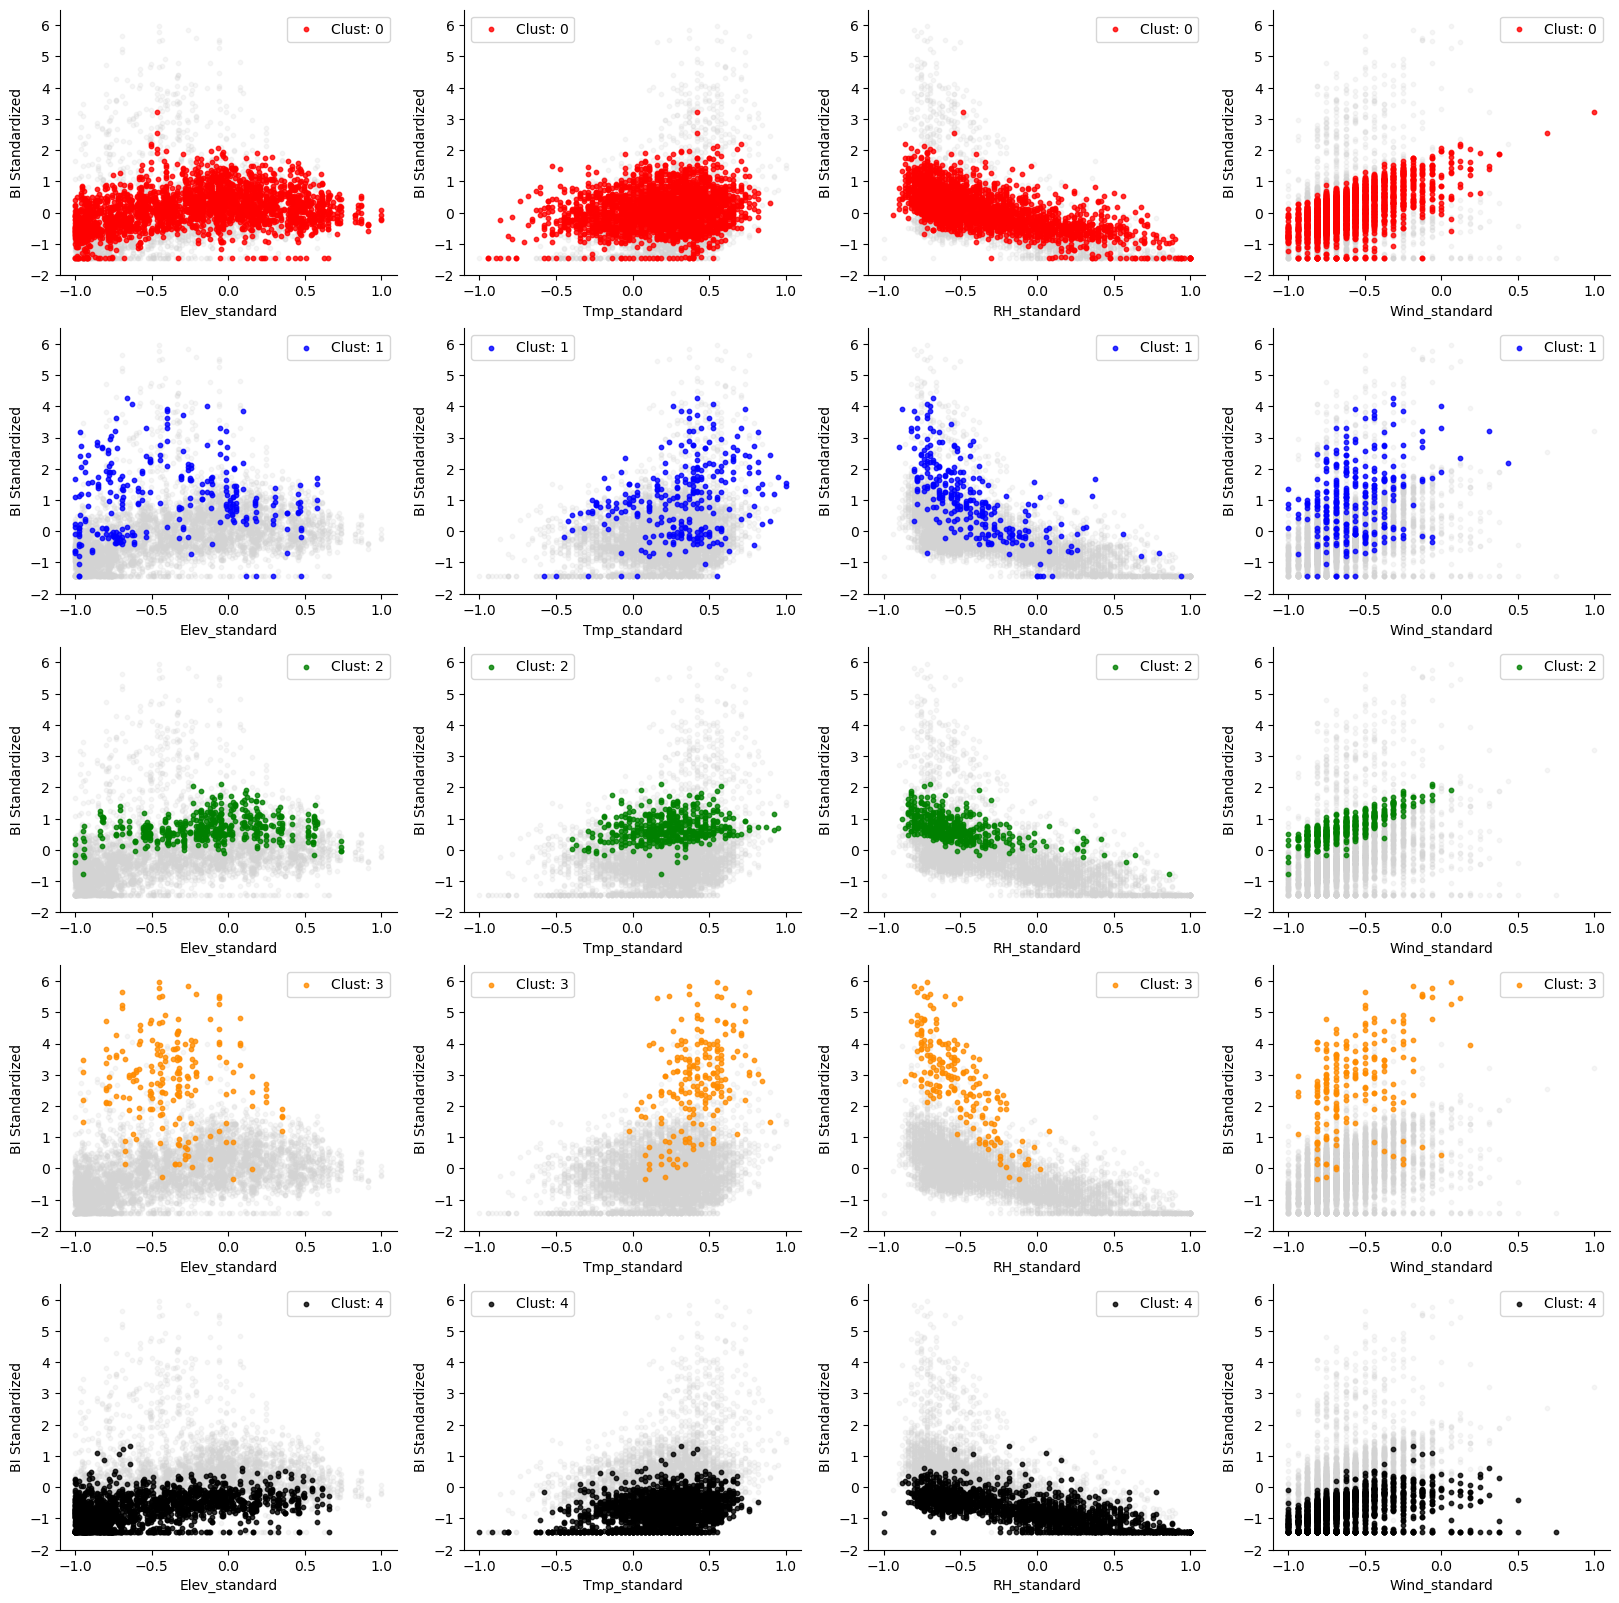

In [101]:
n_clusters = agglo_cluster_solution_rep.max()+1
fig, ax = plt.subplots(n_clusters,4,figsize=(20,4*n_clusters))

for k in range(n_clusters):
    for j,covar_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):

        x_vals_plot = Xs[:,:,j].reshape(-1)
        y_vals_plot = y_long.reshape(-1)
        agglo_clust_plot = agglo_cluster_solution_rep.reshape(-1)

        x_vals_plot_k = x_vals_plot[np.where(agglo_clust_plot==k)[0]]
        y_vals_plot_k = y_vals_plot[np.where(agglo_clust_plot==k)[0]]
        
        x_vals_plot_k_remain = x_vals_plot[np.where(agglo_clust_plot!=k)[0]]
        y_vals_plot_k_remain = y_vals_plot[np.where(agglo_clust_plot!=k)[0]]   
        

        ax[k,j].scatter(x_vals_plot_k_remain, y_vals_plot_k_remain,
            s=10,
           color='lightgrey', alpha=0.2)
        
        ax[k,j].scatter(x_vals_plot_k, y_vals_plot_k,
                    s=10,
                   color=agglo_cols[k], alpha=0.8, label=f'Clust: {k}')


        ax[k,j].set_xlabel(covar_name)
        ax[k,j].set_ylabel('BI Standardized')
        ax[k,j].spines[['right', 'top']].set_visible(False)
        ax[k,j].set_ylim([-2,6.5])
        ax[k,j].legend()
#plt.savefig('Exp Results/Xu Dataset/Longi Run 2/Clustering_plot_sep.png')

plt.show()

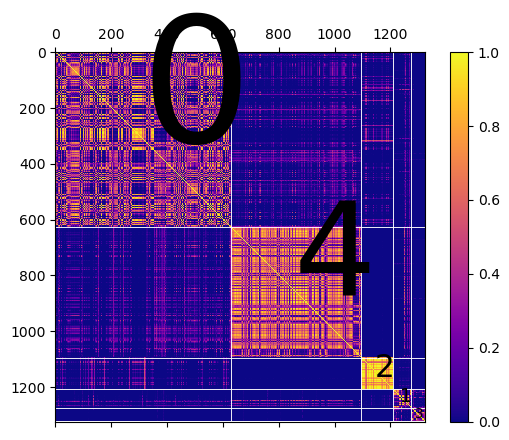

In [104]:
# Calculate c-vals
c_vals = calc_c_vals(agglo_cluster_solution, normalized_sim_mat)

sorted_clust_names = pd.Series(agglo_cluster_solution).value_counts().index

arranged_ids = []
for c in sorted_clust_names:

    clust_ids = np.where(agglo_cluster_solution==c)[0]
    c_vals_clust = c_vals[clust_ids]
    sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]
    
    arranged_ids.append(sorted_clust_ids)
    
arranged_ids = np.concatenate(arranged_ids)

sorted_matrix = np.zeros((len(Ys),len(Ys)))

for i in range(len(Ys)):
    for j in range(len(Ys)):
        
        sorted_matrix[i,j] = normalized_sim_mat[arranged_ids[i], arranged_ids[j]]

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(sorted_matrix, cmap='plasma')
figure.colorbar(caxes)

clust_sizes = pd.Series(agglo_cluster_solution).value_counts().values

for clust_size,clust_name, n in zip(clust_sizes,sorted_clust_names,clust_sizes.cumsum()):
    
    axes.axvline(n-1,c='white',lw=0.65)
    axes.axhline(n-1,c='white',lw=0.65)

    axes.text(n-clust_size//2-10, n-clust_size//2+10, str(clust_name), color="k", fontsize=clust_size/5)


#plt.savefig('Exp Results/Xu Dataset/Longi Run 1/mixture_QR_conf_plot.png')
plt.show()

In [105]:
pd.Series(agglo_cluster_solution).value_counts()

0    629
4    467
2    113
1     67
3     48
Name: count, dtype: int64

### Plot Clusters on Map

In [106]:
station_info_df

Stn ID        Stn Name   Lat   Long    State  Long_adj Agglo_clusters
0    12302  TERRAPIN CREEK  33.8  -85.5  Alabama     -85.5             C2
0    12701          TALLGA  33.4   86.0  Alabama     -86.0             C2
0    12801     SCHOOLHOUSE  33.1   86.0  Alabama     -86.0             C2
0    12902     SHOAL CREEK  33.6   85.6  Alabama     -85.6             C2
0    13201       OAKMULGEE  32.9   87.1  Alabama     -87.1             C2
..     ...             ...   ...    ...      ...       ...            ...
0   482012  SANDSTONE RAWS  41.1  107.2  Wyoming    -107.2             C0
0   482102      ESTERBROOK  42.4  105.3  Wyoming    -105.3             C0
0   482105    SAWMILL PARK  41.0  106.1  Wyoming    -106.1             C0
0   482106     DODGE CREEK  41.9  105.5  Wyoming    -105.5             C0
0   483101        GUERNSEY  42.3  104.8  Wyoming    -104.8             C0

[1324 rows x 7 columns]

In [107]:
import plotly.express as px

agglo_cluster_solution_with_prefix = np.array(['C' + x for x in agglo_cluster_solution.astype('str')])
station_info_df['posterior_clusters'] =agglo_cluster_solution_with_prefix


color_list = ['red', 'blue', 'green', 'darkorange', 'black', 'purple', 'brown', 'grey']
color_dict_map = {'C'+str(i): color_list[i] for i in range(len(color_list))}

# Assuming wildfire_data_df_xu is your DataFrame
fig = px.scatter_geo(station_info_df, lat='Lat',
                     lon='Long_adj', color='posterior_clusters',
                     scope='usa',color_discrete_map=color_dict_map)
                     
fig.update_traces(marker=dict(size=5))  # Adjust the size as needed
fig.update_geos(showcountries=True,
                countrycolor="Black",
                showsubunits=True, subunitcolor="Black")

fig.update_layout(title='Wildfire Data Map of the USA with State Boundaries - Posterior Clusters',
                  geo=dict(showland=True, landcolor="whitesmoke"))

fig.show()
#fig.write_image("Exp Results/Xu Dataset/Run 1/Elev/posterior_cluster_map.png")

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Do exemplar Modelling

In [346]:
color_list = ['red','blue',
            'green','darkorange','black','purple','brown']

In [347]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

c_id = cluster_ids[2]

# Extract points in that cluster
cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

# Choose k and get top k point
k = int(len(cluster_member_id)*0.05)
point_wise_scores = np.sum(points_sim, 1)
sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]

In [348]:
Xs[cluster_exemplar_ids].shape

(10, 4, 4)

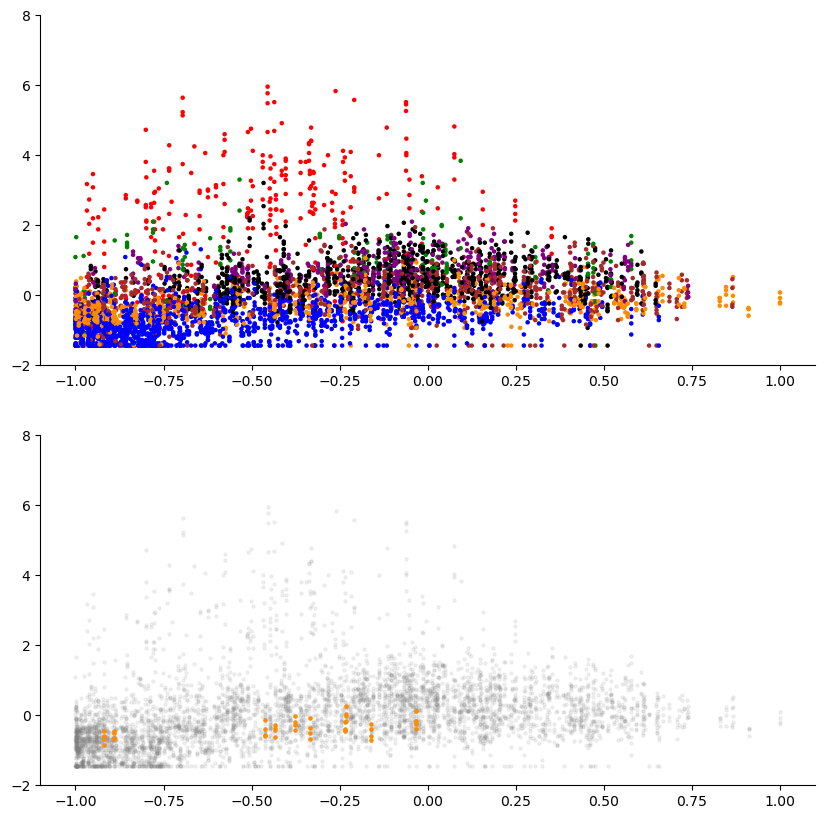

In [349]:
# Plot for sanity check
fig, ax = plt.subplots(2,1,figsize=(10,10))


ax[0].scatter(Xs[:,:,0].reshape(-1),
              Ys.reshape(-1),
              c=[color_list[i] for i in agglo_clust_plot],alpha=1, s=5)
ax[0].set_ylim([-2,8])
ax[0].spines[['right', 'top']].set_visible(False)


# Plot exemplar
ax[1].scatter(Xs[:,:,0].reshape(-1),
              Ys.reshape(-1), c='gray',alpha=0.1, s=5)
ax[1].set_ylim([-2,8])
ax[1].spines[['right', 'top']].set_visible(False)


xs_cluster = Xs[cluster_exemplar_ids][:,:,0].reshape(-1)
ys_cluster = Ys[cluster_exemplar_ids].reshape(-1)
ax[1].scatter(xs_cluster, ys_cluster, c=color_list[c_id],alpha=1, s=5)

In [350]:
for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):

        exemplar_partitions = partition_samp[cluster_exemplar_ids]

In [351]:
X_train = Xs
y_train = Ys

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/250676298.py:141: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/250676298.py:141: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/250676298.py:141: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/250676298.py:141: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_

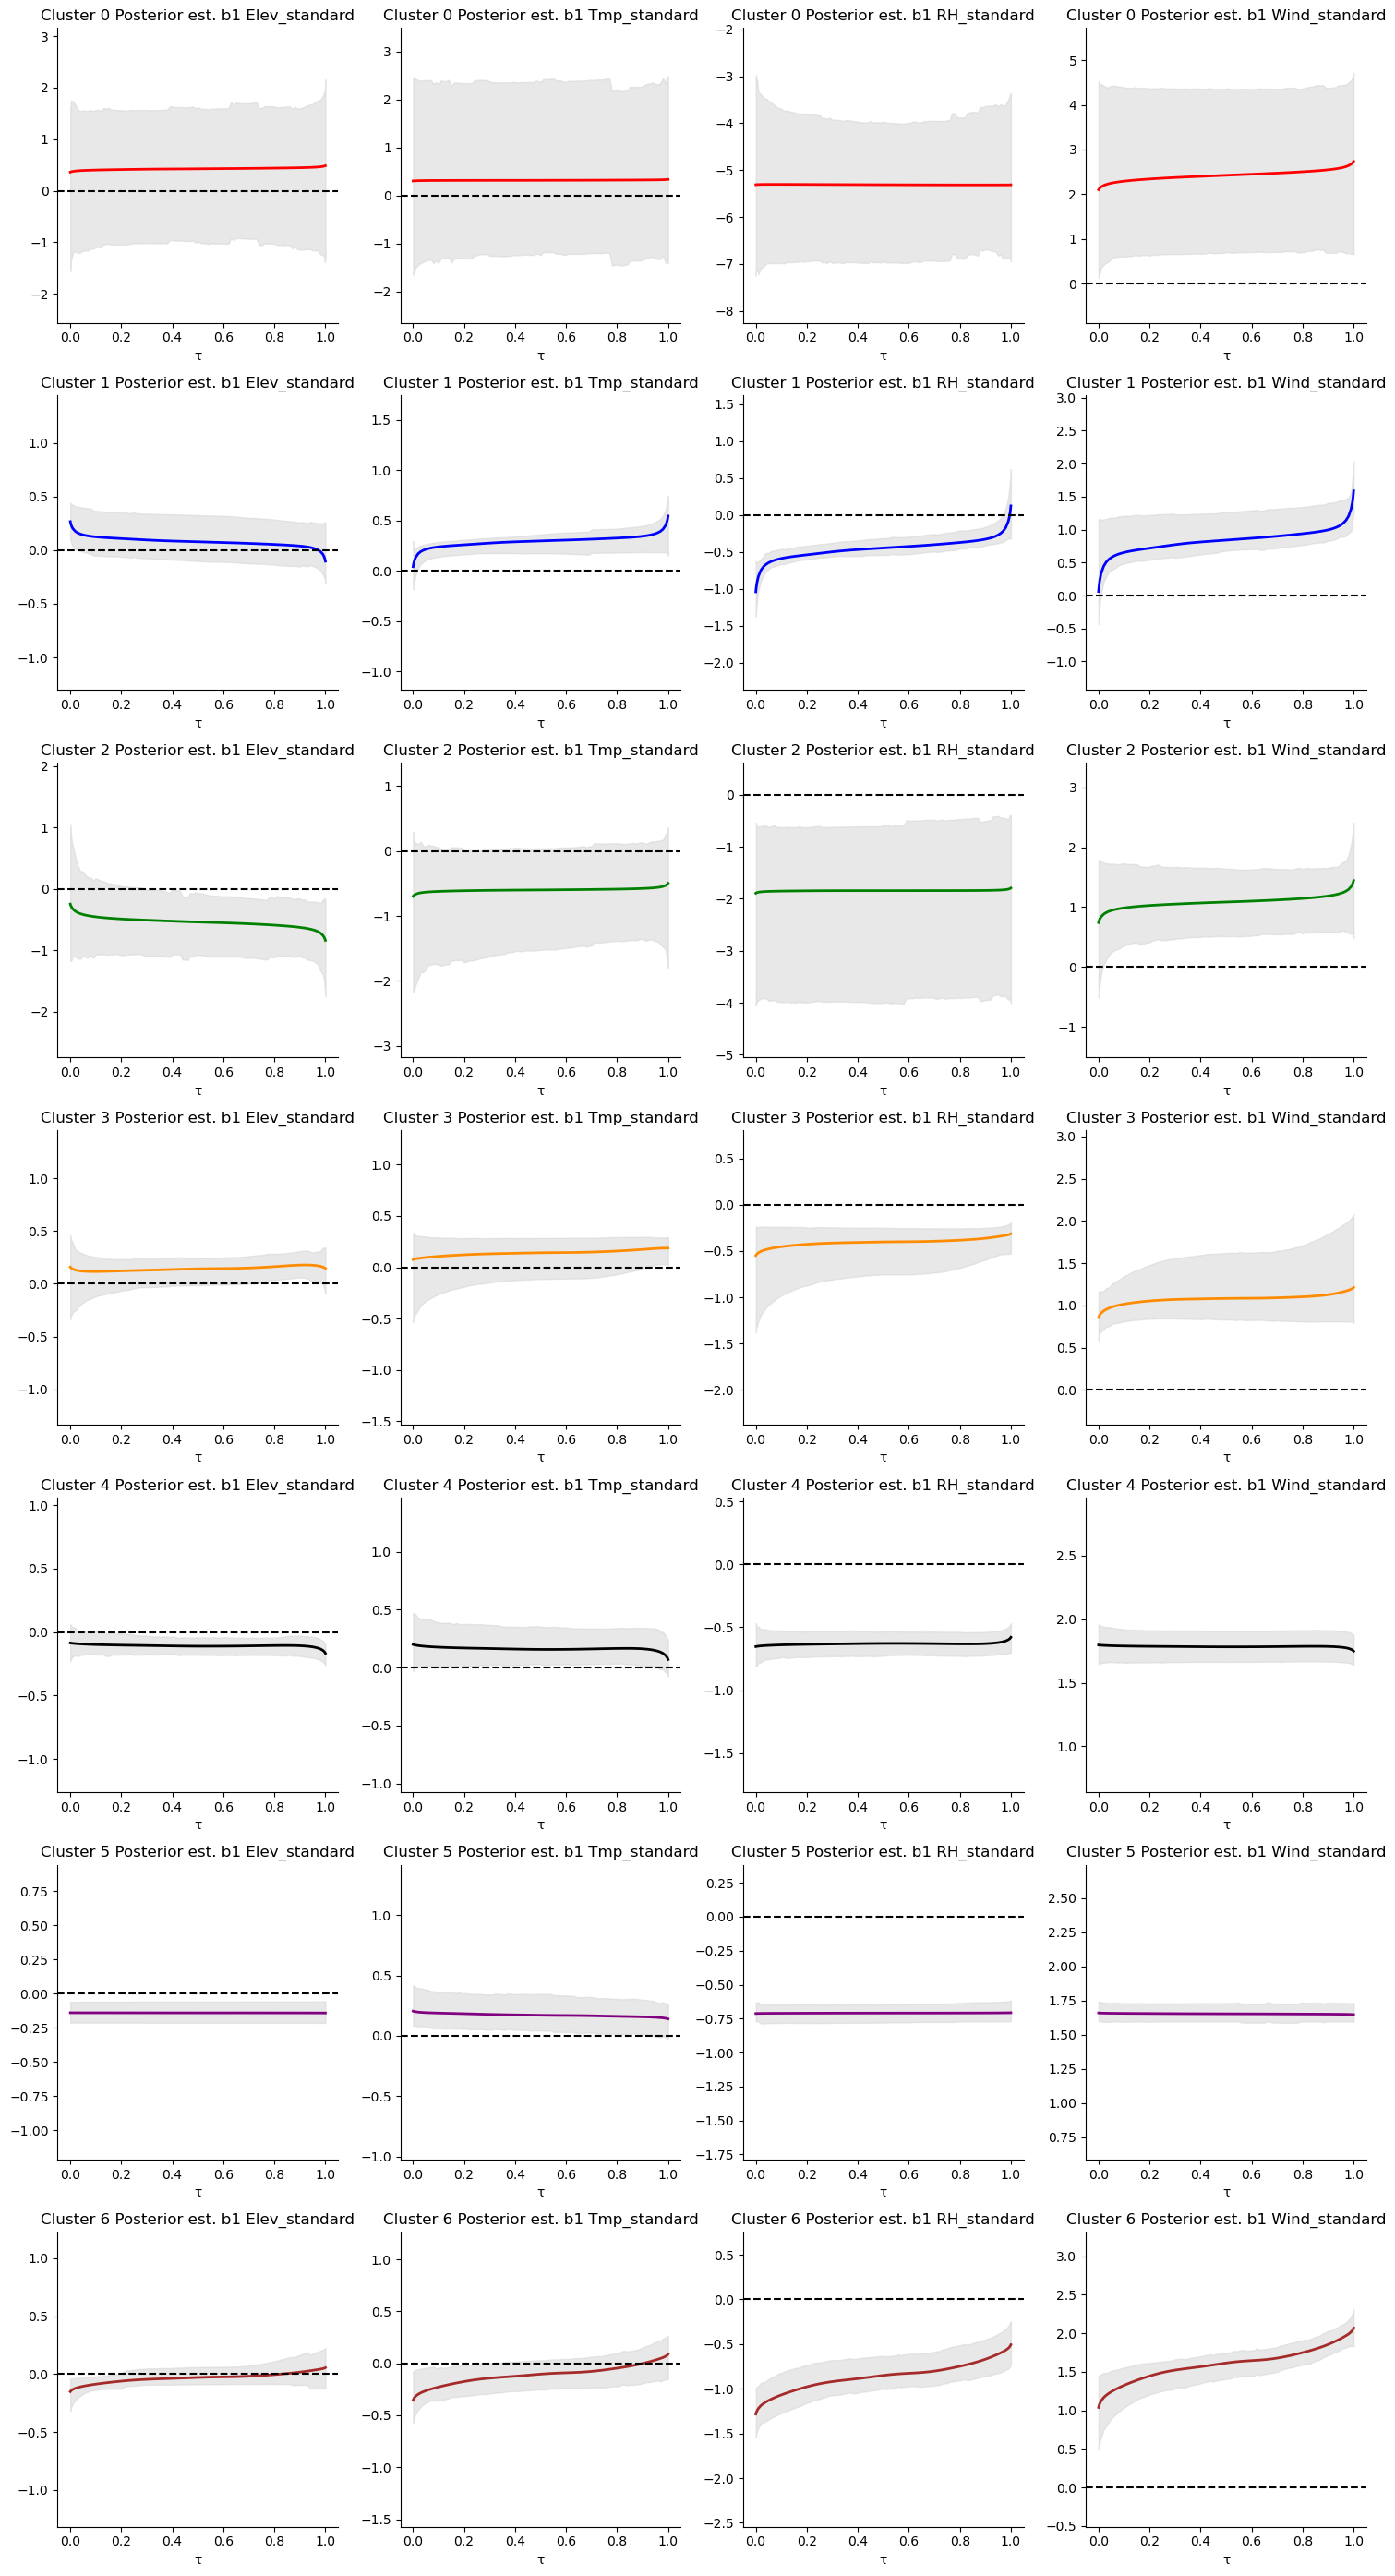

In [352]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), n_covar, figsize=(15,4*len(cluster_ids)))

for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k_size = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k_size]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):
        
        # Extract cluster ids of points chosen as exemplars
        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_samp_clust = phi_samp[k-1,:]

            if multivariate_x:
                if prior_on_t:
                    m = (len(phi_samp_clust)-4 - 2*n_covar)//2
                else:
                    m = (len(phi_samp_clust)-3 - 2*n_covar)//2
            else:
                if prior_on_t:
                    m = (len(phi_samp_clust)-5)//2
                else:
                    m = (len(phi_samp_clust)-4)//2

            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1: 2*m+1+n_covar]


            sigma_1_current = phi_samp_clust[2*m+1+n_covar]
            sigma_2_current = phi_samp_clust[2*m+1+n_covar + 1]

            if prior_on_t:
                v_current = phi_samp_clust[2*m+1+n_covar + 2]
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 3 : 2*m+1+n_covar + 3 + n_covar]  # Fix

            else:
                v_current = base_quantile_v
                v_prop = base_quantile_v
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 2 : 2*m+1+n_covar + 2 +n_covar]  # Fix
                
            
            # Extract all points that would have been in that cluster (for calculating projection)
            

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Project x
            # First extract all x points in given partition to calculate X_a and X_b
            x_vals_k_all = X_train[np.where(partition_samp==k)[0]]
            x_vals_k_all_long = x_vals_k_all.reshape(-1,4)
            
            if len(x_vals_k_all) == 1:
                continue
            projx, X_ak, X_bk = project_x(x_vals_k_all_long,
                                          x_alpha_current, return_ab = True)
            
            
            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)
            
            # Generate beta samples
            beta_1_samp = (gamma_current + (np.expand_dims((1/(2*X_bk))*(eta_2-eta_1),1)*x_alpha_current))
            # Get beta samp
            #beta_0_samp = mu_current + (eta_1 + eta_2)/2
            #beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            #beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)

            beta_weight.append(p_count)


    #beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.array([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])
    
    # Remove anomaly values
    beta_1_expanded = beta_1_expanded * (np.abs(beta_1_expanded) < 1e3).astype('float')

    # Get covariate wise means
    b1_c_mean = np.mean(beta_1_expanded,0)    
    
    # Get CIs
    for cov_id, cov_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
        b1_c_cis = az.hdi(beta_1_expanded[:,:,cov_id])


        # Plot values
        ax[c_id,cov_id].plot(tau_grid, b1_c_mean[:,cov_id], color=color_list[c_id],lw=2)
        ax[c_id,cov_id].fill_between(tau_grid, b1_c_cis[:,0],
                        b1_c_cis[:,1], color='lightgray', alpha=.5)

        ax[c_id,cov_id].title.set_text(f"Cluster {c_id} Posterior est. b1 {cov_name}")

        ax[c_id,cov_id].set_xlabel('τ')
        
        ax[c_id,cov_id].axhline(y=0,linestyle='--', c = 'black')
        
        max_val = np.max(b1_c_cis[:,1])
        min_val = np.min(b1_c_cis[:,0])
        
        ax[c_id,cov_id].set_ylim([min_val-1,max_val+1])

        ax[c_id,cov_id].spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()
plt.savefig(f'Exp Results/Xu Dataset/Longi Run 2/Exemplar_slopes.png')
plt.show()


Same plot but with intercept

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/3200667215.py:142: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/3200667215.py:164: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/3200667215.py:164: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/3200667215.py:164: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_72216/3200667215.py:164: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions



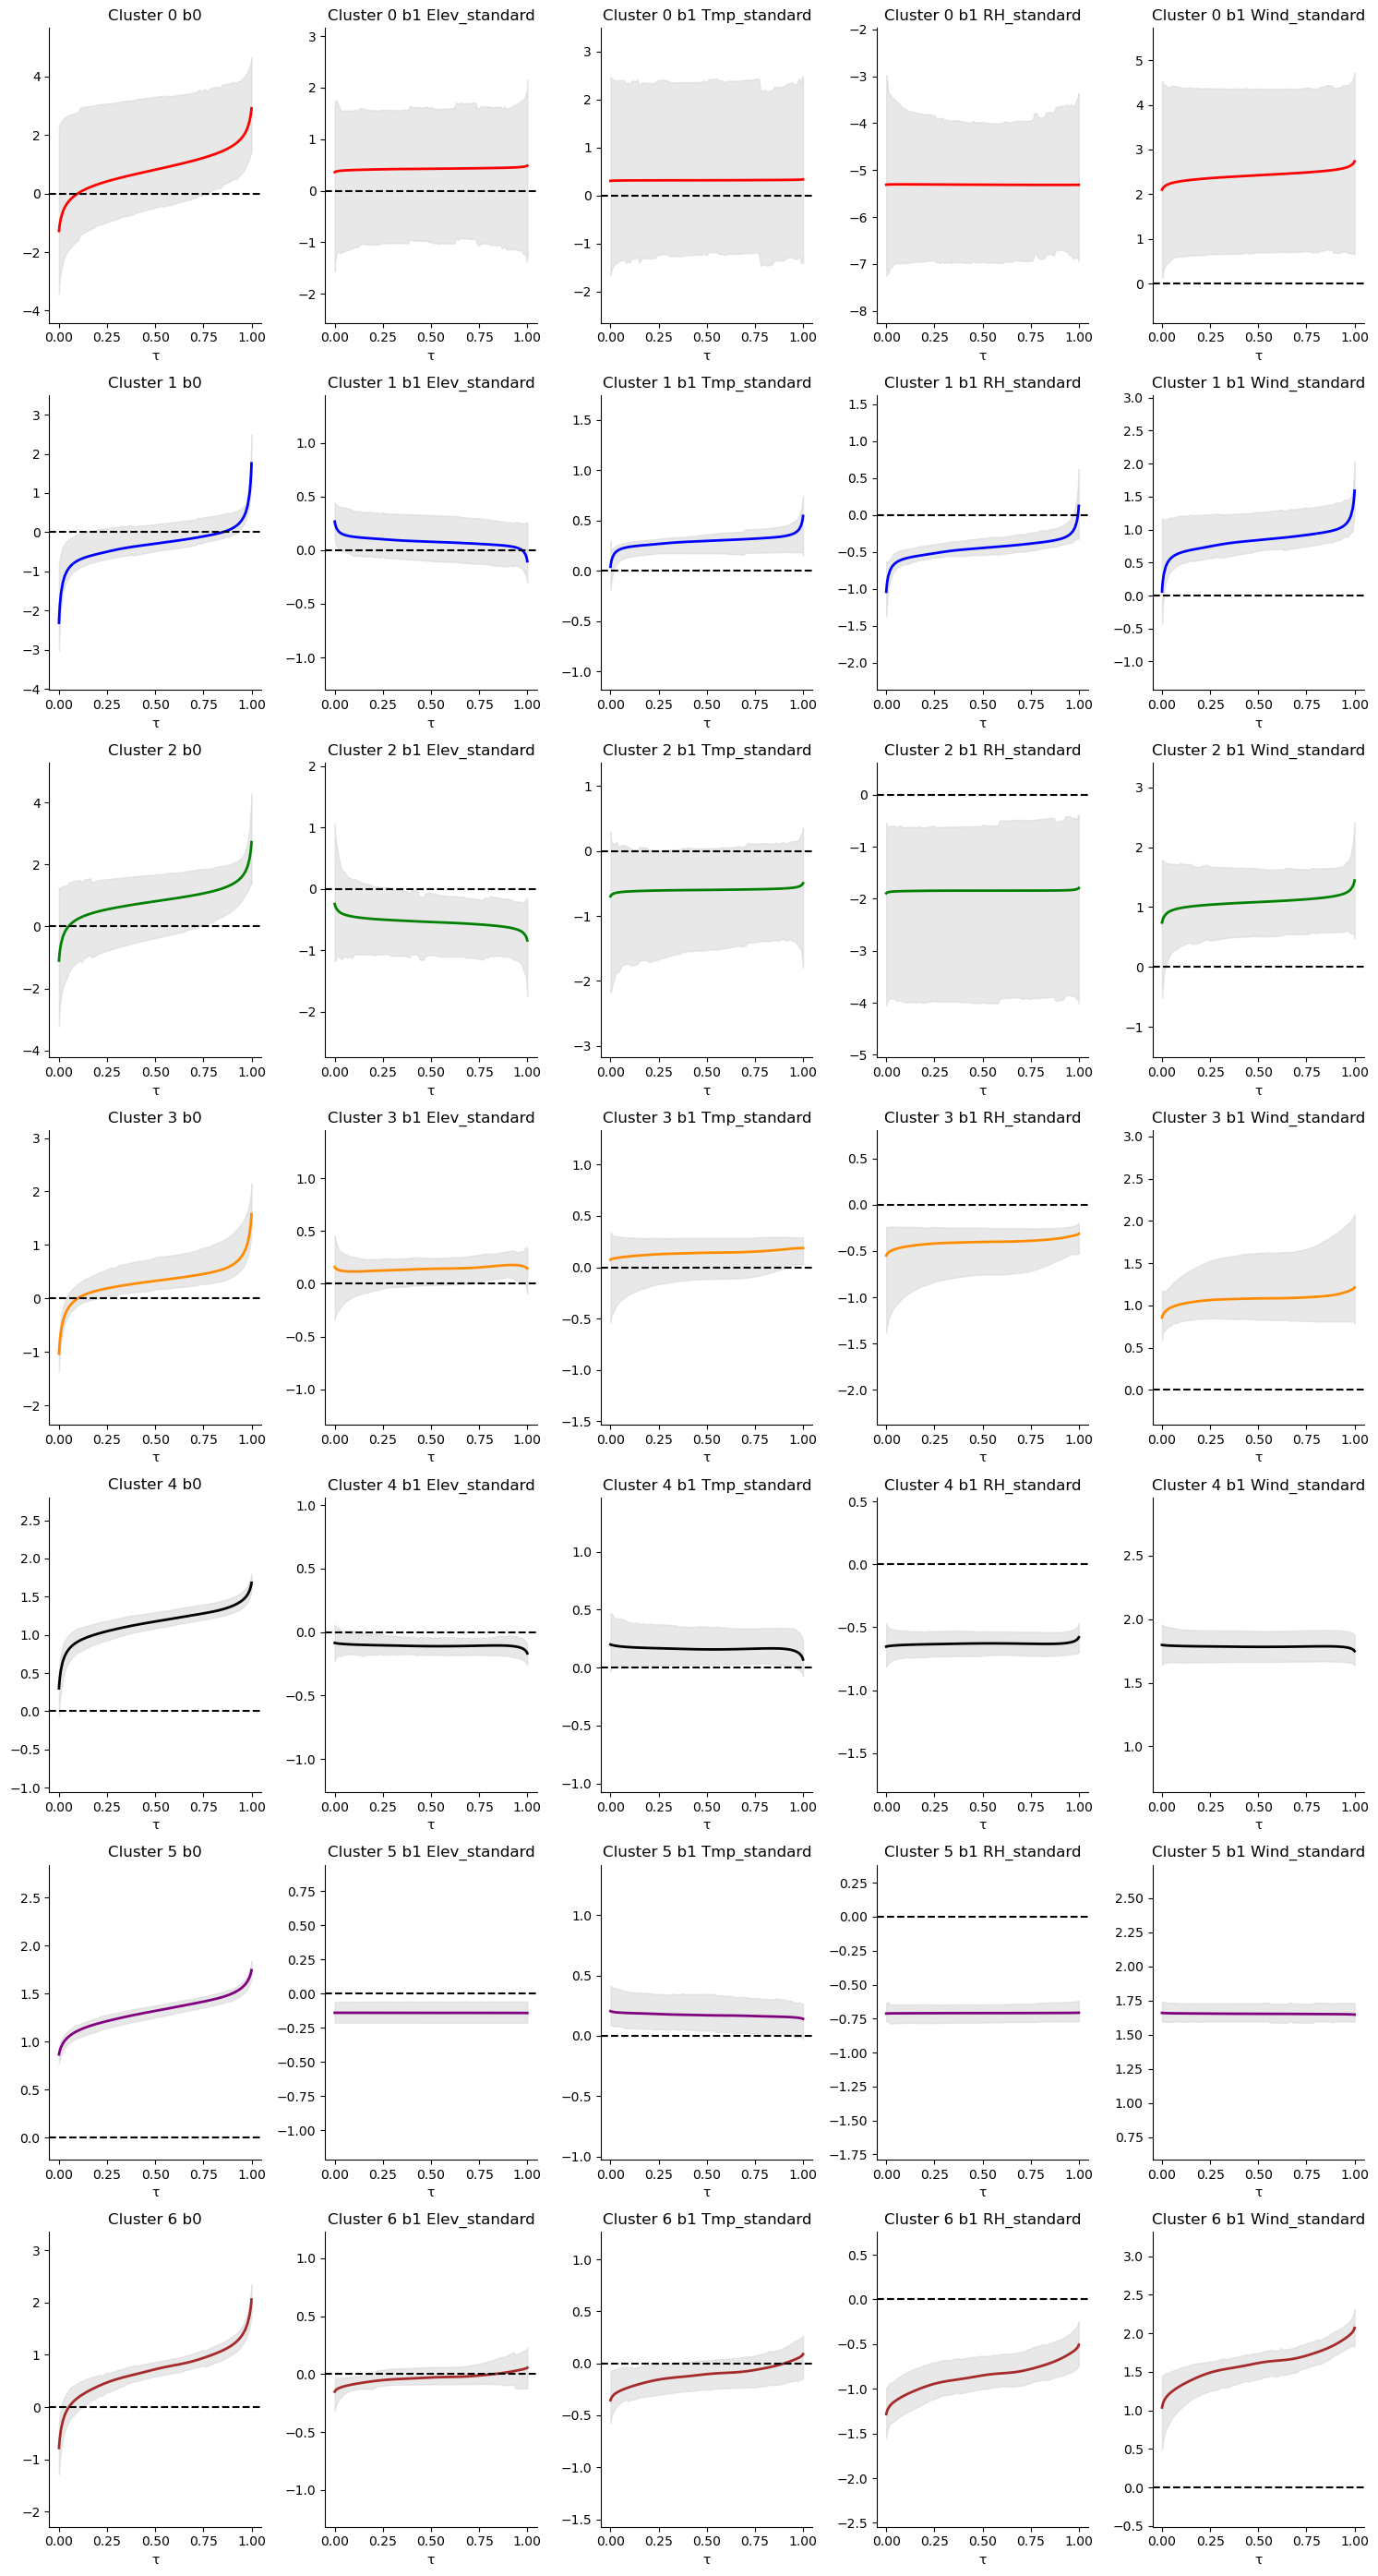

In [353]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), 1+n_covar, figsize=(15,4*len(cluster_ids)))

for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k_size = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k_size]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):
        
        # Extract cluster ids of points chosen as exemplars
        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_samp_clust = phi_samp[k-1,:]

            if multivariate_x:
                if prior_on_t:
                    m = (len(phi_samp_clust)-4 - 2*n_covar)//2
                else:
                    m = (len(phi_samp_clust)-3 - 2*n_covar)//2
            else:
                if prior_on_t:
                    m = (len(phi_samp_clust)-5)//2
                else:
                    m = (len(phi_samp_clust)-4)//2

            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1: 2*m+1+n_covar]


            sigma_1_current = phi_samp_clust[2*m+1+n_covar]
            sigma_2_current = phi_samp_clust[2*m+1+n_covar + 1]

            if prior_on_t:
                v_current = phi_samp_clust[2*m+1+n_covar + 2]
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 3 : 2*m+1+n_covar + 3 + n_covar]  # Fix

            else:
                v_current = base_quantile_v
                v_prop = base_quantile_v
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 2 : 2*m+1+n_covar + 2 +n_covar]  # Fix
                
            
            # Extract all points that would have been in that cluster (for calculating projection)
            

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Project x
            # First extract all x points in given partition to calculate X_a and X_b
            x_vals_k_all = X_train[np.where(partition_samp==k)[0]]
            x_vals_k_all_long = x_vals_k_all.reshape(-1,4)

            if len(x_vals_k_all) == 1:
                continue
            projx, X_ak, X_bk = project_x(x_vals_k_all_long, x_alpha_current, return_ab = True)
            
            
            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)
            
            # Generate beta samples
            beta_1_samp = (gamma_current + (np.expand_dims((1/(2*X_bk))*(eta_2-eta_1),1)*x_alpha_current))
            beta_0_samp = mu_current + 0.5*(eta_2+eta_1) - 0.5*(eta_2-eta_1)*(X_ak/X_bk)
            # Get beta samp
            #beta_0_samp = mu_current + (eta_1 + eta_2)/2
            #beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)

            beta_weight.append(p_count)


    beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.array([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])
    
    # Remove anomaly values
    beta_1_expanded = beta_1_expanded * (np.abs(beta_1_expanded) < 1e3).astype('float')
    beta_0_expanded = beta_0_expanded * (np.abs(beta_0_expanded) < 1e3).astype('float')

    # Get covariate wise means
    b1_c_mean = np.mean(beta_1_expanded,0)    
    b0_c_mean = np.mean(beta_0_expanded,0)    
    
    # Get intercept CI
    b0_c_cis = az.hdi(beta_0_expanded)
  
    # Plot beta 0 
    ax[c_id, 0].plot(tau_grid, b0_c_mean, color=color_list[c_id],lw=2)
    ax[c_id, 0].fill_between(tau_grid, b0_c_cis[:,0],
                    b0_c_cis[:,1], color='lightgray', alpha=.5)

    ax[c_id, 0].title.set_text(f"Cluster {c_id} b0")

    ax[c_id, 0].set_xlabel('τ')

    ax[c_id, 0].axhline(y=0,linestyle='--', c = 'black')

    max_val = np.max(b0_c_cis[:,1])
    min_val = np.min(b0_c_cis[:,0])

    ax[c_id, 0].set_ylim([min_val-1,max_val+1])

    ax[c_id, 0].spines[['right', 'top']].set_visible(False)

    # Get CIs
    for cov_id, cov_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
        b1_c_cis = az.hdi(beta_1_expanded[:,:,cov_id])

        # Plot values
        ax[c_id,cov_id+1].plot(tau_grid, b1_c_mean[:,cov_id], color=color_list[c_id],lw=2)
        ax[c_id,cov_id+1].fill_between(tau_grid, b1_c_cis[:,0],
                        b1_c_cis[:,1], color='lightgray', alpha=.5)

        ax[c_id,cov_id+1].title.set_text(f"Cluster {c_id} b1 {cov_name}")

        ax[c_id,cov_id+1].set_xlabel('τ')
        
        ax[c_id,cov_id+1].axhline(y=0,linestyle='--', c = 'black')
        
        max_val = np.max(b1_c_cis[:,1])
        min_val = np.min(b1_c_cis[:,0])
        
        ax[c_id,cov_id+1].set_ylim([min_val-1,max_val+1])

        ax[c_id,cov_id+1].spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()
plt.savefig(f'Exp Results/Xu Dataset/Longi Run 2/Exemplar_slopes_with_intercept.png')
plt.show()


### Plot posterior quantile lines

In [354]:
def extract_submatrix(in_mat, delete_pos):
    return np.delete(in_mat, delete_pos)

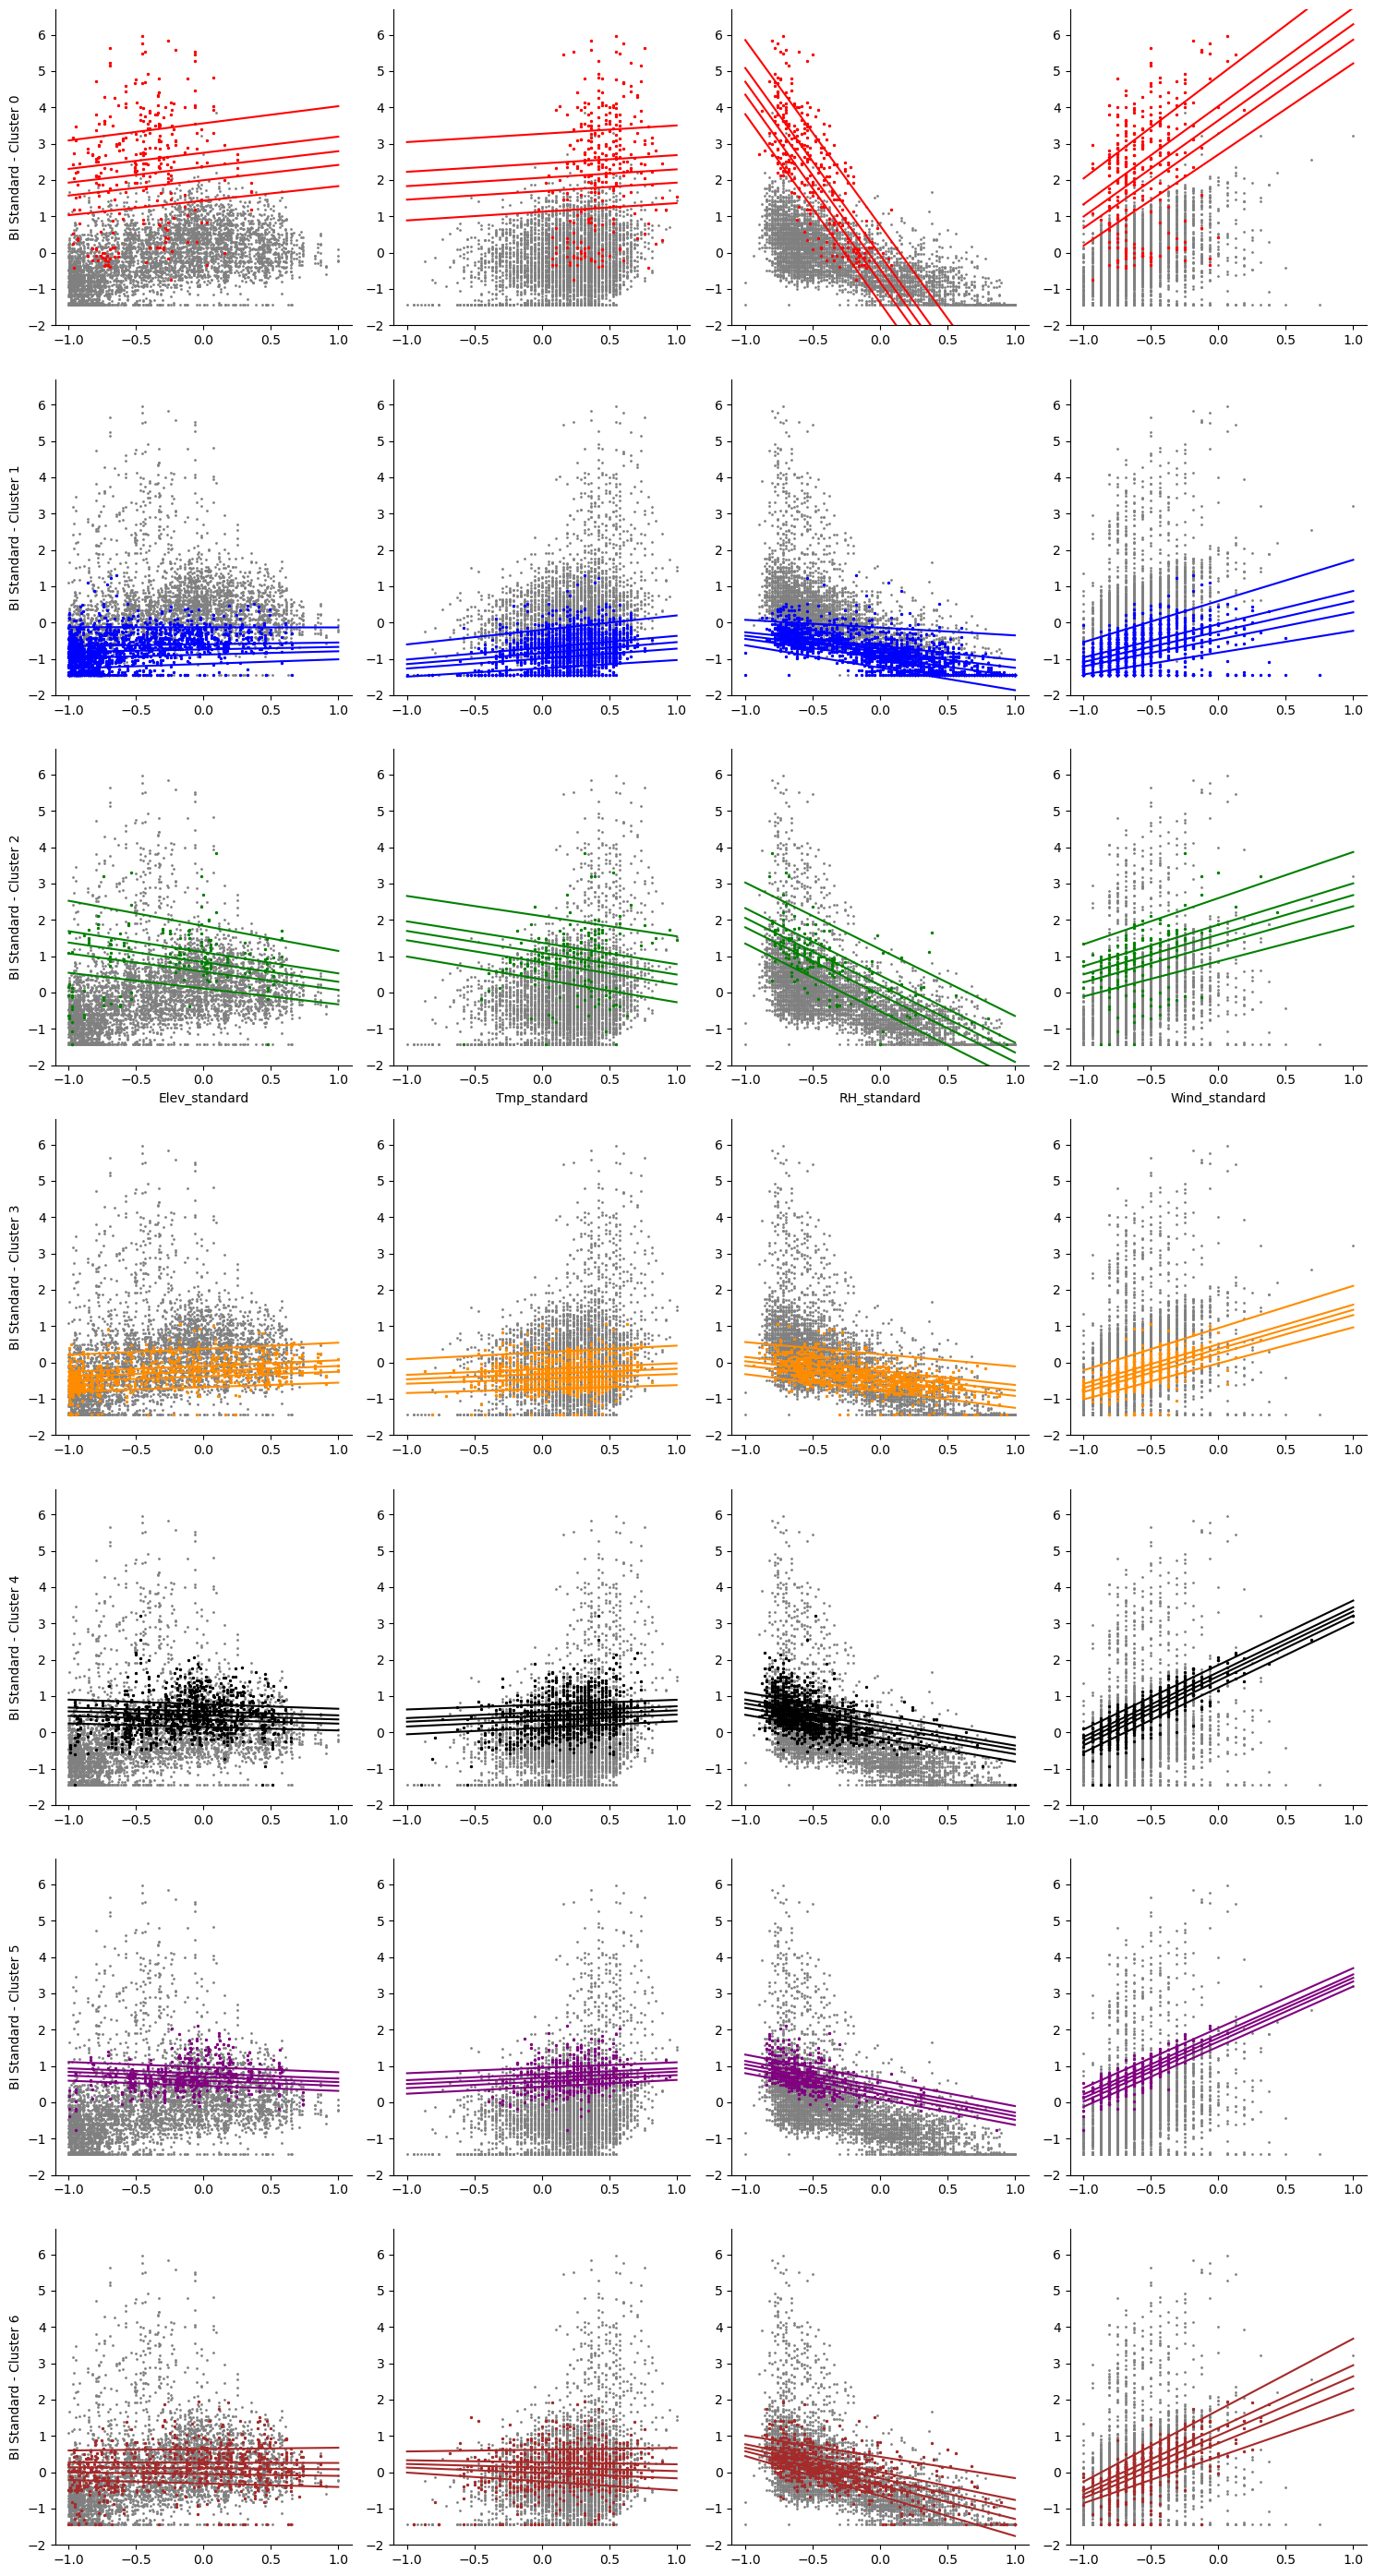

In [355]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), n_covar, figsize=(15,4*len(cluster_ids)))

for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k_size = int(len(cluster_member_id)*0.1)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k_size]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []
    
    # Also need to save gamma, eta2 eta 1, alpha, b
    gamma_save = []
    eta_1_save = []
    eta_2_save = []
    alpha_save = []
    b_save = []
    
    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):
        
        # Extract cluster ids of points chosen as exemplars
        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_samp_clust = phi_samp[k-1,:]

            if multivariate_x:
                if prior_on_t:
                    m = (len(phi_samp_clust)-4 - 2*n_covar)//2
                else:
                    m = (len(phi_samp_clust)-3 - 2*n_covar)//2
            else:
                if prior_on_t:
                    m = (len(phi_samp_clust)-5)//2
                else:
                    m = (len(phi_samp_clust)-4)//2

            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1: 2*m+1+n_covar]


            sigma_1_current = phi_samp_clust[2*m+1+n_covar]
            sigma_2_current = phi_samp_clust[2*m+1+n_covar + 1]

            if prior_on_t:
                v_current = phi_samp_clust[2*m+1+n_covar + 2]
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 3 : 2*m+1+n_covar + 3 + n_covar]  # Fix

            else:
                v_current = base_quantile_v
                v_prop = base_quantile_v
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 2 : 2*m+1+n_covar + 2 +n_covar]  # Fix
                
            
            # Extract all points that would have been in that cluster (for calculating projection)
            

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Project x
            # First extract all x points in given partition to calculate X_a and X_b
            x_vals_k_all = X_train[np.where(partition_samp==k)[0]]
            x_vals_k_all_long = x_vals_k_all.reshape(-1,4)

            y_vals_k_all = y_train[np.where(partition_samp==k)[0]]
            if len(x_vals_k_all) == 1:
                continue
            projx, X_ak, X_bk = project_x(x_vals_k_all_long, x_alpha_current, return_ab = True)
            
            
            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)
            
            # Generate beta samples
            beta_1_samp = (gamma_current + (np.expand_dims((1/(2*X_bk))*(eta_2-eta_1),1)*x_alpha_current))
            beta_0_samp = mu_current + 0.5*(eta_2+eta_1) - 0.5*(eta_2-eta_1)*(X_ak/X_bk)
            

            beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)
            
            gamma_save.append(gamma_current)
            eta_1_save.append(eta_1)
            eta_2_save.append(eta_2)
            alpha_save.append(x_alpha_current)
            b_save.append(X_bk)

            beta_weight.append(p_count)


    beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.array([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])
    
    # Expand other variables
    gamma_expanded = np.vstack([g for g, count in zip(gamma_save, beta_weight) for _ in range(count)])
    eta_1_expanded = np.vstack([g for g, count in zip(eta_1_save, beta_weight) for _ in range(count)])
    eta_2_expanded = np.vstack([g for g, count in zip(eta_2_save, beta_weight) for _ in range(count)])
    alpha_expanded = np.vstack([g for g, count in zip(alpha_save, beta_weight) for _ in range(count)])
    b_var_expanded = np.vstack([g for g, count in zip(b_save, beta_weight) for _ in range(count)])
    
    
    # Remove anomaly values
    beta_1_expanded = beta_1_expanded * (np.abs(beta_1_expanded) < 1e3).astype('float')
    beta_0_expanded = beta_0_expanded * (np.abs(beta_0_expanded) < 1e3).astype('float')

    # Get covariate wise means
    b1_c_mean = np.mean(beta_1_expanded,0)    
    b0_c_mean = np.mean(beta_0_expanded,0)    
    
    # Get intercept CI
    # Get CIs
    x_vals_k_all_plot = X_train[np.where(agglo_cluster_solution==c_id)[0]]
    x_vals_k_all_plot_long = x_vals_k_all_plot.reshape(-1,4)  # N*T x 4
    y_vals_k_all = y_train[np.where(agglo_cluster_solution==c_id)[0]]
    
    # Calculate cluster means
    x_vals_k_all_mean = x_vals_k_all_plot_long.mean(0)
    
    # calculate addition intercept terms
    gamma_mean = gamma_expanded.mean(0)
    eta_1_mean = eta_1_expanded.mean(0)
    eta_2_mean = eta_2_expanded.mean(0)
    alpha_expanded_mean = alpha_expanded.mean(0)
    b_var_expanded_mean = b_var_expanded.mean(0)
    
    X_train_long = X_train.reshape(-1,4)
    y_train_long = y_train.reshape(-1)
    
    for cov_id, cov_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):

        
        x_vals_k_all_mean_wanted = extract_submatrix(x_vals_k_all_mean, cov_id)
        gamma_wanted = extract_submatrix(gamma_mean,cov_id)
        alpha_wanted = extract_submatrix(alpha_expanded_mean, cov_id)
        
        b0_additional = (x_vals_k_all_mean_wanted@gamma_wanted) +\
            ((eta_2_mean - eta_1_mean)/(2*b_var_expanded_mean)) *\
        (x_vals_k_all_mean_wanted@alpha_wanted)


        
        
        # Grab x and y vals
        x_cov_k = x_vals_k_all_plot_long[:,cov_id]
        
        # Plot values
        ax[c_id,cov_id].scatter(X_train_long[:,cov_id], y_train_long, c='gray', s=1)
        
        ax[c_id,cov_id].scatter(x_cov_k, y_vals_k_all.reshape(-1), c=color_list[c_id], s=2)
        
        # Plot Lines
        sample_quantiles = [0.05,0.25,0.5,0.75,0.95]
        sample_quantile_inds = [np.argwhere(tau_grid_expanded==q)[0][0] for q in sample_quantiles]
        x_grid = np.linspace(min(X_train_long[:,cov_id]), max(X_train_long[:,cov_id]), 20)
        
        for sample_quantile_id in sample_quantile_inds:
            
            b0_sq = b0_c_mean[sample_quantile_id]
            b1_sq = b1_c_mean[sample_quantile_id,cov_id]
            
            y_pred = b0_sq + x_grid*b1_sq + b0_additional[sample_quantile_id]
            
            ax[c_id,cov_id].plot(x_grid, y_pred, c=color_list[c_id])

        ax[c_id,cov_id].spines[['right', 'top']].set_visible(False)
        
        if cov_id == 0:
            ax[c_id,cov_id].set_ylabel(f'BI Standard - Cluster {c_id}')
        
        if c_id == 2:
            ax[c_id,cov_id].set_xlabel(cov_name)
            
        ax[c_id,cov_id].set_ylim([-2,6.7])


    
plt.tight_layout()
plt.savefig(f'Exp Results/Xu Dataset/Longi Run 2/Exemplar_lines.png')
plt.show()